# 

In [1]:
import pandas as pd
#from pmdarima.arima import auto_arima
import prophet
#85 percent train 15 percent test

Importing plotly failed. Interactive plots will not work.


In [2]:
prophet.Prophet()

In [3]:
df = pd.read_csv('variable_selected_county_dataset.csv', index_col=0)

In [5]:
import warnings
from statsmodels.tools.sm_exceptions import ConvergenceWarning
from statsmodels.tools.sm_exceptions import ValueWarning
from sklearn.metrics import r2_score, mean_squared_error
from statsmodels.tsa.arima.model import ARIMA

warnings.filterwarnings('ignore', category=ValueWarning)
warnings.filterwarnings('ignore', category=ConvergenceWarning)
warnings.filterwarnings('ignore')
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import statsmodels.api as sm

from statsmodels.tsa.stattools import adfuller

data = pd.read_csv('variable_selected_county_dataset.csv').iloc[:, 1:]


def difference(df):
    df['incremental_cases'] = df['incremental_cases'].diff().fillna(df['incremental_cases'])
    return df


chicago = data[data['entity'] == 'Florida-Miami-Dade'].loc[:, ['date', 'incremental_cases']]
chicago['incremental_cases'] = chicago['incremental_cases'].astype('int')
chicago['date'] = pd.to_datetime(chicago['date'], format="%Y-%m-%d")

# use 85%-15% for train-test split
train = chicago.iloc[:230, :]
test = chicago.iloc[230:, :]

def stationary_test(series):
    result = adfuller(series)
    return (result[0], result[1])

# NYC data is stationary without any differencing
stationary_test(train.incremental_cases)

(-1.642344912578238, 0.4610357721284504)

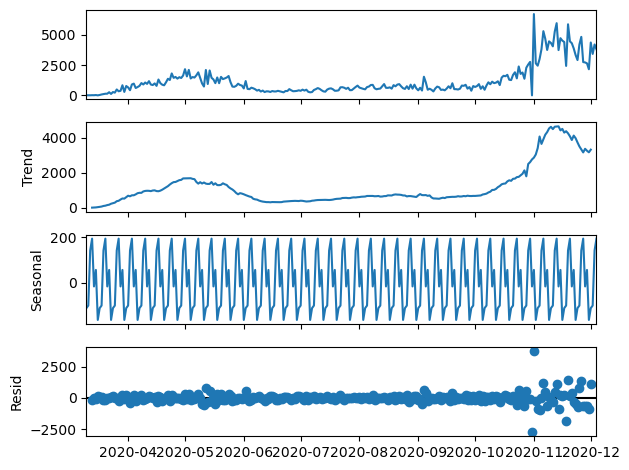

In [7]:
from statsmodels.tsa.seasonal import seasonal_decompose

analysis = chicago.set_index('date').copy()


decompose_result_mult = seasonal_decompose(analysis)

trend = decompose_result_mult.trend
seasonal = decompose_result_mult.seasonal
residual = decompose_result_mult.resid

decompose_result_mult.plot();

In [24]:
for x in decompose_result_mult.seasonal:
    print(x)

-36.423795976427556
16.61633814265394
12.724446250762039
20.365677707782975
23.508534850640114
-1.5102621418410929
-35.280938833570424
-36.423795976427556
16.61633814265394
12.724446250762039
20.365677707782975
23.508534850640114
-1.5102621418410929
-35.280938833570424
-36.423795976427556
16.61633814265394
12.724446250762039
20.365677707782975
23.508534850640114
-1.5102621418410929
-35.280938833570424
-36.423795976427556
16.61633814265394
12.724446250762039
20.365677707782975
23.508534850640114
-1.5102621418410929
-35.280938833570424
-36.423795976427556
16.61633814265394
12.724446250762039
20.365677707782975
23.508534850640114
-1.5102621418410929
-35.280938833570424
-36.423795976427556
16.61633814265394
12.724446250762039
20.365677707782975
23.508534850640114
-1.5102621418410929
-35.280938833570424
-36.423795976427556
16.61633814265394
12.724446250762039
20.365677707782975
23.508534850640114
-1.5102621418410929
-35.280938833570424
-36.423795976427556
16.61633814265394
12.72444625076203

In [4]:
arimaModel = chicago[['date', 'incremental_cases']]
arimaModel.rename(columns={"date": "ds", "incremental_cases": "y"}, inplace=True)
train = arimaModel.head(int(0.85*len(arimaModel))+1)
test = arimaModel.tail(int(0.15*len(arimaModel)))

In [17]:
train

,ds,y
1620,2020-03-10,2
1621,2020-03-11,9
1622,2020-03-12,13
1623,2020-03-13,10
1624,2020-03-14,28
...,...,...
1845,2020-10-21,133
1846,2020-10-22,77
1847,2020-10-23,101
1848,2020-10-24,161


11:02:52 - cmdstanpy - INFO - Chain [1] start processing
11:02:52 - cmdstanpy - INFO - Chain [1] done processing


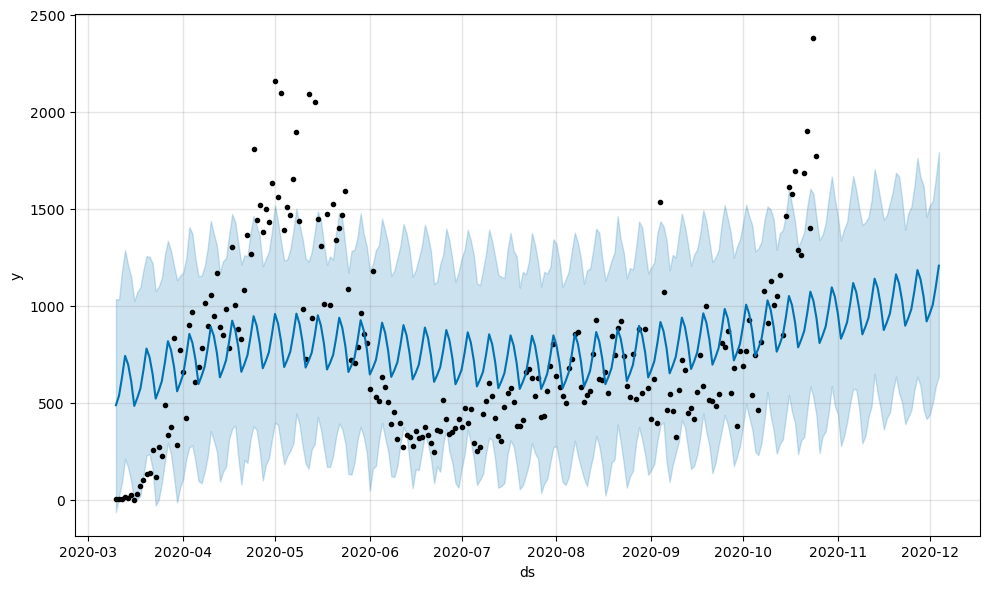

In [9]:
baseModel = prophet.Prophet().fit(train)
future = baseModel.make_future_dataframe(periods=40)
forecast = baseModel.predict(future)
baseModel.plot(forecast);

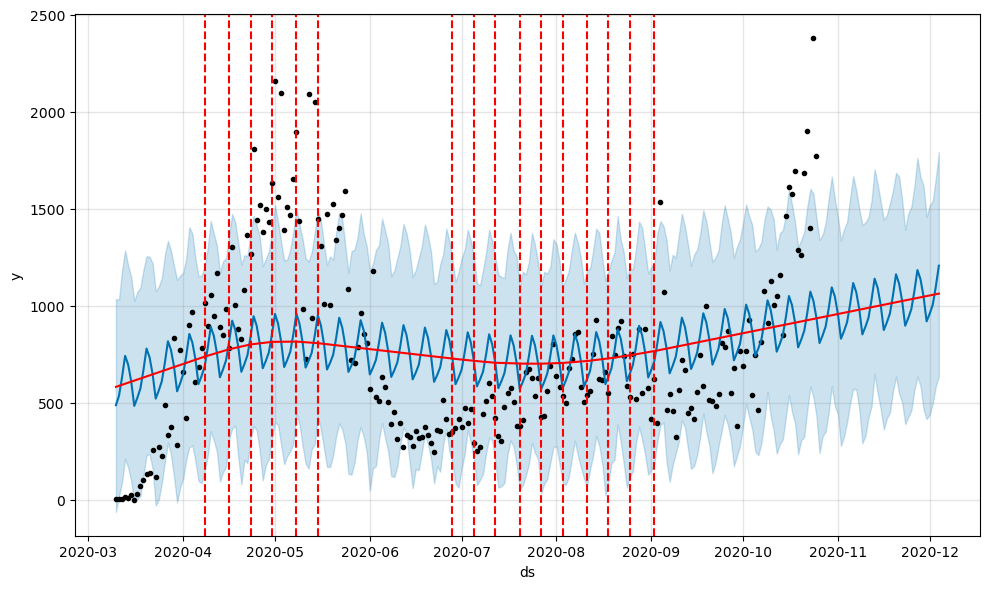

In [10]:
from prophet.plot import add_changepoints_to_plot

# Change points to plot
fig = baseModel.plot(forecast)
a = add_changepoints_to_plot(fig.gca(), baseModel, forecast)

In [7]:
import statsmodels.api as sm

In [6]:
COVID = pd.DataFrame({
    'holiday': 'COVID',
    'ds': pd.to_datetime(['2020-03-15']),
    'lower_window': -15,
    'upper_window': 15,
})

# Super Bowl time window
superbowl = pd.DataFrame({
    'holiday': 'superbowl',
    'ds': pd.to_datetime(['2020-02-02']),
    'lower_window': -7,
    'upper_window': 1,
})

# Combine all events
events = pd.concat((COVID, superbowl))

In [8]:
dfToUse = df[df['entity'] == 'Florida-Miami-Dade']
dfToUse.rename(columns={"date": "ds", "incremental_cases": "y"}, inplace=True)
foo = dfToUse.copy().drop(labels=['ds','entity','y','cases'],axis=1)
non_floats = []
for col in foo:
    if foo[col].dtypes == "float64":
        non_floats.append(col)
foo.drop(labels=non_floats,axis=1,inplace=True)
    
dummyDF = pd.get_dummies(dfToUse, columns=foo.columns.tolist())



In [9]:
toDrop = dummyDF.columns[dummyDF.nunique() == 1].tolist()
#toDrop.pop()
#dfToUse.drop(labels=toDrop, axis=1, inplace=True)
dummyDF.drop(labels=toDrop, axis=1, inplace=True)

In [66]:
dummyDF.ds

193     2020-03-10
205     2020-03-11
217     2020-03-12
229     2020-03-13
241     2020-03-14
           ...    
3373    2020-11-30
3385    2020-12-01
3397    2020-12-02
3409    2020-12-03
3421    2020-12-04
Name: ds, Length: 270, dtype: object

In [11]:

train = dummyDF[dummyDF['ds'] < '2020-10-26'].sort_values(by=['ds']).reset_index().drop(labels=['index'],axis=1)
test = dummyDF[dummyDF['ds'] >= '2020-10-26']

In [71]:
train

,ds,cases,mean_temp,min_temp,max_temp,dewpoint,sea_level_pressure,station_pressure,visibility,wind_speed,...,dewpoint_3d_avg,y,stay_at_home_announced_no,stay_at_home_announced_yes,stay_at_home_effective_no,stay_at_home_effective_yes,"station_name_CHICAGO MIDWAY AIRPORT, IL US",precip_flag_A,precip_flag_G,precip_flag_I
0,2020-03-10,17,43.9,36.0,55.0,39.2,1020.7,995.7,8.2,10.4,...,36.366667,6.0,True,False,True,False,True,False,True,False
1,2020-03-11,22,38.5,34.0,44.1,31.0,1019.6,996.3,7.9,5.0,...,34.966667,5.0,True,False,True,False,True,False,True,False
2,2020-03-12,27,44.6,36.0,55.9,34.7,1010.8,988.0,8.0,7.5,...,30.866667,5.0,True,False,True,False,True,False,True,False
3,2020-03-13,40,43.4,34.0,55.0,26.9,1018.1,994.4,9.6,14.8,...,27.733333,13.0,True,False,True,False,True,False,True,False
4,2020-03-14,51,38.7,33.1,45.0,21.6,1032.0,8.5,9.5,9.5,...,24.600000,11.0,True,False,True,False,True,False,True,False
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
225,2020-10-21,168139,50.8,46.0,57.9,43.4,1020.7,997.0,7.7,7.5,...,44.433333,1682.0,False,True,False,True,True,False,True,False
226,2020-10-22,170039,57.5,48.0,79.0,51.9,1016.5,995.6,5.6,9.3,...,49.566667,1900.0,False,True,False,True,True,False,True,False
227,2020-10-23,171437,60.5,44.6,73.9,53.4,1012.2,990.6,8.7,11.8,...,45.066667,1398.0,False,True,False,True,True,False,True,False
228,2020-10-24,173817,41.5,35.1,46.9,29.9,1025.0,1.7,10.0,9.0,...,38.633333,2380.0,False,True,False,True,True,False,True,False


In [72]:
train

,ds,cases,mean_temp,min_temp,max_temp,dewpoint,sea_level_pressure,station_pressure,visibility,wind_speed,...,dewpoint_3d_avg,y,stay_at_home_announced_no,stay_at_home_announced_yes,stay_at_home_effective_no,stay_at_home_effective_yes,"station_name_CHICAGO MIDWAY AIRPORT, IL US",precip_flag_A,precip_flag_G,precip_flag_I
0,2020-03-10,17,43.9,36.0,55.0,39.2,1020.7,995.7,8.2,10.4,...,36.366667,6.0,True,False,True,False,True,False,True,False
1,2020-03-11,22,38.5,34.0,44.1,31.0,1019.6,996.3,7.9,5.0,...,34.966667,5.0,True,False,True,False,True,False,True,False
2,2020-03-12,27,44.6,36.0,55.9,34.7,1010.8,988.0,8.0,7.5,...,30.866667,5.0,True,False,True,False,True,False,True,False
3,2020-03-13,40,43.4,34.0,55.0,26.9,1018.1,994.4,9.6,14.8,...,27.733333,13.0,True,False,True,False,True,False,True,False
4,2020-03-14,51,38.7,33.1,45.0,21.6,1032.0,8.5,9.5,9.5,...,24.600000,11.0,True,False,True,False,True,False,True,False
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
225,2020-10-21,168139,50.8,46.0,57.9,43.4,1020.7,997.0,7.7,7.5,...,44.433333,1682.0,False,True,False,True,True,False,True,False
226,2020-10-22,170039,57.5,48.0,79.0,51.9,1016.5,995.6,5.6,9.3,...,49.566667,1900.0,False,True,False,True,True,False,True,False
227,2020-10-23,171437,60.5,44.6,73.9,53.4,1012.2,990.6,8.7,11.8,...,45.066667,1398.0,False,True,False,True,True,False,True,False
228,2020-10-24,173817,41.5,35.1,46.9,29.9,1025.0,1.7,10.0,9.0,...,38.633333,2380.0,False,True,False,True,True,False,True,False


In [12]:
from sklearn.model_selection import TimeSeriesSplit
from sklearn.metrics import mean_squared_error
import numpy as np

#train.reset_index(inplace=True)

n_splits = 3

tscv = TimeSeriesSplit(n_splits=n_splits)

changepoint_prior_scale = [0.001, 0.01, 0.1, 0.5]
seasonality_prior_scale =  [0.01, 0.1, 1.0, 10.0]
holidays_prior_scale = [0.01, 0.1, 1.0, 10.0]
seasonality_mode = ['additive', 'multiplicative']

best_score, best_cfg = float("inf"), None


    
for h in holidays_prior_scale:
    for c in changepoint_prior_scale:
        for s in seasonality_prior_scale:
            for m in seasonality_mode:
                avg = 0
                print((h,c,s,m))
                for train_index, val_index in tscv.split(train):
                    train_data, val_data = train.loc[train_index, :], train.loc[val_index, :]
                    val_data.fillna(0, inplace=True)
                    train_data.fillna(0, inplace=True)
                    model=prophet.Prophet(holidays=events, holidays_prior_scale=h, changepoint_prior_scale=c, seasonality_prior_scale=s,
                                         seasonality_mode = m,yearly_seasonality=True, weekly_seasonality=True)
                    for ii in train_data.columns:
                        if ii == 'index':
                            continue
                        if ii == 'ds':
                            continue
                        if ii == 'cases':
                            continue
                        if ii == 'y':
                            continue
                        model.add_regressor(ii)
                    model.add_country_holidays(country_name='US')
                    model.fit(train_data)
                    #future = model.make_future_dataframe(periods=val_data.shape[0])
                    #future = future[future['ds'] > train_data.ds.iloc[-1]]
                    forecast = model.predict(val_data)
                    mse = mean_squared_error(val_data.y, forecast.yhat)
                    avg += mse
                if avg < best_score:
                    best_score, best_cfg = avg, (h,c,s,m)

print(f'Best ARIMA parameters: {best_cfg} with MSE: {best_score}')

(0.01, 0.001, 0.01, 'additive')


23:35:30 - cmdstanpy - INFO - Chain [1] start processing
23:35:31 - cmdstanpy - INFO - Chain [1] done processing
23:35:31 - cmdstanpy - INFO - Chain [1] start processing
23:35:31 - cmdstanpy - INFO - Chain [1] done processing
23:35:31 - cmdstanpy - ERROR - Chain [1] error: error during processing Operation not permitted
Optimization terminated abnormally. Falling back to Newton.
23:35:32 - cmdstanpy - INFO - Chain [1] start processing
23:35:33 - cmdstanpy - INFO - Chain [1] done processing
23:35:33 - cmdstanpy - INFO - Chain [1] start processing
23:35:33 - cmdstanpy - INFO - Chain [1] done processing
23:35:33 - cmdstanpy - ERROR - Chain [1] error: error during processing Operation not permitted
Optimization terminated abnormally. Falling back to Newton.
23:35:33 - cmdstanpy - INFO - Chain [1] start processing
23:35:35 - cmdstanpy - INFO - Chain [1] done processing


(0.01, 0.001, 0.01, 'multiplicative')


23:35:35 - cmdstanpy - INFO - Chain [1] start processing
23:35:36 - cmdstanpy - INFO - Chain [1] done processing
23:35:36 - cmdstanpy - INFO - Chain [1] start processing
23:35:36 - cmdstanpy - INFO - Chain [1] done processing
23:35:36 - cmdstanpy - ERROR - Chain [1] error: error during processing Operation not permitted
Optimization terminated abnormally. Falling back to Newton.
23:35:37 - cmdstanpy - INFO - Chain [1] start processing
23:35:39 - cmdstanpy - INFO - Chain [1] done processing
23:35:39 - cmdstanpy - INFO - Chain [1] start processing
23:35:39 - cmdstanpy - INFO - Chain [1] done processing
23:35:39 - cmdstanpy - ERROR - Chain [1] error: error during processing Operation not permitted
Optimization terminated abnormally. Falling back to Newton.
23:35:40 - cmdstanpy - INFO - Chain [1] start processing
23:35:41 - cmdstanpy - INFO - Chain [1] done processing


(0.01, 0.001, 0.1, 'additive')


23:35:42 - cmdstanpy - INFO - Chain [1] start processing
23:35:43 - cmdstanpy - INFO - Chain [1] done processing
23:35:44 - cmdstanpy - INFO - Chain [1] start processing
23:35:44 - cmdstanpy - INFO - Chain [1] done processing
23:35:44 - cmdstanpy - ERROR - Chain [1] error: error during processing Operation not permitted
Optimization terminated abnormally. Falling back to Newton.
23:35:44 - cmdstanpy - INFO - Chain [1] start processing
23:36:02 - cmdstanpy - INFO - Chain [1] done processing
23:36:02 - cmdstanpy - INFO - Chain [1] start processing
23:36:02 - cmdstanpy - INFO - Chain [1] done processing
23:36:02 - cmdstanpy - ERROR - Chain [1] error: error during processing Operation not permitted
Optimization terminated abnormally. Falling back to Newton.
23:36:02 - cmdstanpy - INFO - Chain [1] start processing
23:36:18 - cmdstanpy - INFO - Chain [1] done processing


(0.01, 0.001, 0.1, 'multiplicative')


23:36:19 - cmdstanpy - INFO - Chain [1] start processing
23:36:22 - cmdstanpy - INFO - Chain [1] done processing
23:36:22 - cmdstanpy - INFO - Chain [1] start processing
23:36:22 - cmdstanpy - INFO - Chain [1] done processing
23:36:22 - cmdstanpy - ERROR - Chain [1] error: error during processing Operation not permitted
Optimization terminated abnormally. Falling back to Newton.
23:36:22 - cmdstanpy - INFO - Chain [1] start processing
23:36:24 - cmdstanpy - INFO - Chain [1] done processing
23:36:25 - cmdstanpy - INFO - Chain [1] start processing
23:36:25 - cmdstanpy - INFO - Chain [1] done processing
23:36:25 - cmdstanpy - ERROR - Chain [1] error: error during processing Operation not permitted
Optimization terminated abnormally. Falling back to Newton.
23:36:25 - cmdstanpy - INFO - Chain [1] start processing
23:36:27 - cmdstanpy - INFO - Chain [1] done processing


(0.01, 0.001, 1.0, 'additive')


23:36:27 - cmdstanpy - INFO - Chain [1] start processing
23:36:28 - cmdstanpy - INFO - Chain [1] done processing
23:36:29 - cmdstanpy - INFO - Chain [1] start processing
23:36:29 - cmdstanpy - INFO - Chain [1] done processing
23:36:29 - cmdstanpy - ERROR - Chain [1] error: error during processing Operation not permitted
Optimization terminated abnormally. Falling back to Newton.
23:36:29 - cmdstanpy - INFO - Chain [1] start processing
23:36:29 - cmdstanpy - INFO - Chain [1] done processing
23:36:30 - cmdstanpy - INFO - Chain [1] start processing
23:36:30 - cmdstanpy - INFO - Chain [1] done processing
23:36:30 - cmdstanpy - ERROR - Chain [1] error: error during processing Operation not permitted
Optimization terminated abnormally. Falling back to Newton.
23:36:30 - cmdstanpy - INFO - Chain [1] start processing
23:36:31 - cmdstanpy - INFO - Chain [1] done processing


(0.01, 0.001, 1.0, 'multiplicative')


23:36:32 - cmdstanpy - INFO - Chain [1] start processing
23:36:36 - cmdstanpy - INFO - Chain [1] done processing
23:36:37 - cmdstanpy - INFO - Chain [1] start processing
23:36:37 - cmdstanpy - INFO - Chain [1] done processing
23:36:37 - cmdstanpy - ERROR - Chain [1] error: error during processing Operation not permitted
Optimization terminated abnormally. Falling back to Newton.
23:36:37 - cmdstanpy - INFO - Chain [1] start processing
23:36:42 - cmdstanpy - INFO - Chain [1] done processing
23:36:42 - cmdstanpy - INFO - Chain [1] start processing
23:36:42 - cmdstanpy - INFO - Chain [1] done processing
23:36:42 - cmdstanpy - ERROR - Chain [1] error: error during processing Operation not permitted
Optimization terminated abnormally. Falling back to Newton.
23:36:43 - cmdstanpy - INFO - Chain [1] start processing
23:36:45 - cmdstanpy - INFO - Chain [1] done processing


(0.01, 0.001, 10.0, 'additive')


23:36:45 - cmdstanpy - INFO - Chain [1] start processing
23:37:06 - cmdstanpy - INFO - Chain [1] done processing
23:37:07 - cmdstanpy - INFO - Chain [1] start processing
23:37:07 - cmdstanpy - INFO - Chain [1] done processing
23:37:07 - cmdstanpy - ERROR - Chain [1] error: error during processing Operation not permitted
Optimization terminated abnormally. Falling back to Newton.
23:37:07 - cmdstanpy - INFO - Chain [1] start processing
23:37:08 - cmdstanpy - INFO - Chain [1] done processing
23:37:08 - cmdstanpy - INFO - Chain [1] start processing
23:37:08 - cmdstanpy - INFO - Chain [1] done processing
23:37:08 - cmdstanpy - ERROR - Chain [1] error: error during processing Operation not permitted
Optimization terminated abnormally. Falling back to Newton.
23:37:08 - cmdstanpy - INFO - Chain [1] start processing
23:37:10 - cmdstanpy - INFO - Chain [1] done processing


(0.01, 0.001, 10.0, 'multiplicative')


23:37:10 - cmdstanpy - INFO - Chain [1] start processing
23:37:13 - cmdstanpy - INFO - Chain [1] done processing
23:37:13 - cmdstanpy - INFO - Chain [1] start processing
23:37:13 - cmdstanpy - INFO - Chain [1] done processing
23:37:13 - cmdstanpy - ERROR - Chain [1] error: error during processing Operation not permitted
Optimization terminated abnormally. Falling back to Newton.
23:37:13 - cmdstanpy - INFO - Chain [1] start processing
23:38:41 - cmdstanpy - INFO - Chain [1] done processing
23:38:41 - cmdstanpy - INFO - Chain [1] start processing
23:38:42 - cmdstanpy - INFO - Chain [1] done processing
23:38:42 - cmdstanpy - ERROR - Chain [1] error: error during processing Operation not permitted
Optimization terminated abnormally. Falling back to Newton.
23:38:42 - cmdstanpy - INFO - Chain [1] start processing
23:38:48 - cmdstanpy - INFO - Chain [1] done processing


(0.01, 0.01, 0.01, 'additive')


23:38:49 - cmdstanpy - INFO - Chain [1] start processing
23:38:50 - cmdstanpy - INFO - Chain [1] done processing
23:38:50 - cmdstanpy - INFO - Chain [1] start processing
23:38:50 - cmdstanpy - INFO - Chain [1] done processing
23:38:50 - cmdstanpy - ERROR - Chain [1] error: error during processing Operation not permitted
Optimization terminated abnormally. Falling back to Newton.
23:38:50 - cmdstanpy - INFO - Chain [1] start processing
23:38:52 - cmdstanpy - INFO - Chain [1] done processing
23:38:52 - cmdstanpy - INFO - Chain [1] start processing
23:38:52 - cmdstanpy - INFO - Chain [1] done processing


(0.01, 0.01, 0.01, 'multiplicative')


23:38:53 - cmdstanpy - INFO - Chain [1] start processing
23:38:54 - cmdstanpy - INFO - Chain [1] done processing
23:38:54 - cmdstanpy - INFO - Chain [1] start processing
23:38:54 - cmdstanpy - INFO - Chain [1] done processing
23:38:54 - cmdstanpy - ERROR - Chain [1] error: error during processing Operation not permitted
Optimization terminated abnormally. Falling back to Newton.
23:38:54 - cmdstanpy - INFO - Chain [1] start processing
23:38:56 - cmdstanpy - INFO - Chain [1] done processing
23:38:56 - cmdstanpy - INFO - Chain [1] start processing
23:38:56 - cmdstanpy - INFO - Chain [1] done processing


(0.01, 0.01, 0.1, 'additive')


23:38:57 - cmdstanpy - INFO - Chain [1] start processing
23:38:58 - cmdstanpy - INFO - Chain [1] done processing
23:38:58 - cmdstanpy - INFO - Chain [1] start processing
23:38:58 - cmdstanpy - INFO - Chain [1] done processing
23:38:58 - cmdstanpy - ERROR - Chain [1] error: error during processing Operation not permitted
Optimization terminated abnormally. Falling back to Newton.
23:38:58 - cmdstanpy - INFO - Chain [1] start processing
23:38:59 - cmdstanpy - INFO - Chain [1] done processing
23:39:00 - cmdstanpy - INFO - Chain [1] start processing
23:39:00 - cmdstanpy - INFO - Chain [1] done processing


(0.01, 0.01, 0.1, 'multiplicative')


23:39:00 - cmdstanpy - INFO - Chain [1] start processing
23:39:01 - cmdstanpy - INFO - Chain [1] done processing
23:39:01 - cmdstanpy - INFO - Chain [1] start processing
23:39:01 - cmdstanpy - INFO - Chain [1] done processing
23:39:01 - cmdstanpy - ERROR - Chain [1] error: error during processing Operation not permitted
Optimization terminated abnormally. Falling back to Newton.
23:39:02 - cmdstanpy - INFO - Chain [1] start processing
23:39:03 - cmdstanpy - INFO - Chain [1] done processing
23:39:03 - cmdstanpy - INFO - Chain [1] start processing
23:39:03 - cmdstanpy - INFO - Chain [1] done processing


(0.01, 0.01, 1.0, 'additive')


23:39:04 - cmdstanpy - INFO - Chain [1] start processing
23:39:04 - cmdstanpy - INFO - Chain [1] done processing
23:39:05 - cmdstanpy - INFO - Chain [1] start processing
23:39:05 - cmdstanpy - INFO - Chain [1] done processing
23:39:05 - cmdstanpy - ERROR - Chain [1] error: error during processing Operation not permitted
Optimization terminated abnormally. Falling back to Newton.
23:39:05 - cmdstanpy - INFO - Chain [1] start processing
23:39:06 - cmdstanpy - INFO - Chain [1] done processing
23:39:06 - cmdstanpy - INFO - Chain [1] start processing
23:39:07 - cmdstanpy - INFO - Chain [1] done processing


(0.01, 0.01, 1.0, 'multiplicative')


23:39:07 - cmdstanpy - INFO - Chain [1] start processing
23:39:12 - cmdstanpy - INFO - Chain [1] done processing
23:39:13 - cmdstanpy - INFO - Chain [1] start processing
23:39:13 - cmdstanpy - INFO - Chain [1] done processing
23:39:13 - cmdstanpy - ERROR - Chain [1] error: error during processing Operation not permitted
Optimization terminated abnormally. Falling back to Newton.
23:39:13 - cmdstanpy - INFO - Chain [1] start processing
23:39:31 - cmdstanpy - INFO - Chain [1] done processing
23:39:32 - cmdstanpy - INFO - Chain [1] start processing
23:39:32 - cmdstanpy - INFO - Chain [1] done processing


(0.01, 0.01, 10.0, 'additive')


23:39:32 - cmdstanpy - INFO - Chain [1] start processing
23:39:33 - cmdstanpy - INFO - Chain [1] done processing
23:39:33 - cmdstanpy - INFO - Chain [1] start processing
23:39:33 - cmdstanpy - INFO - Chain [1] done processing
23:39:33 - cmdstanpy - ERROR - Chain [1] error: error during processing Operation not permitted
Optimization terminated abnormally. Falling back to Newton.
23:39:33 - cmdstanpy - INFO - Chain [1] start processing
23:39:35 - cmdstanpy - INFO - Chain [1] done processing
23:39:35 - cmdstanpy - INFO - Chain [1] start processing
23:39:35 - cmdstanpy - INFO - Chain [1] done processing


(0.01, 0.01, 10.0, 'multiplicative')


23:39:35 - cmdstanpy - INFO - Chain [1] start processing
23:39:50 - cmdstanpy - INFO - Chain [1] done processing
23:39:51 - cmdstanpy - INFO - Chain [1] start processing
23:39:51 - cmdstanpy - INFO - Chain [1] done processing
23:39:51 - cmdstanpy - ERROR - Chain [1] error: error during processing Operation not permitted
Optimization terminated abnormally. Falling back to Newton.
23:39:51 - cmdstanpy - INFO - Chain [1] start processing
23:39:55 - cmdstanpy - INFO - Chain [1] done processing
23:39:55 - cmdstanpy - INFO - Chain [1] start processing
23:39:55 - cmdstanpy - INFO - Chain [1] done processing


(0.01, 0.1, 0.01, 'additive')


23:39:56 - cmdstanpy - INFO - Chain [1] start processing
23:39:57 - cmdstanpy - INFO - Chain [1] done processing
23:39:57 - cmdstanpy - INFO - Chain [1] start processing
23:39:58 - cmdstanpy - INFO - Chain [1] done processing
23:39:58 - cmdstanpy - INFO - Chain [1] start processing
23:39:58 - cmdstanpy - INFO - Chain [1] done processing


(0.01, 0.1, 0.01, 'multiplicative')


23:39:59 - cmdstanpy - INFO - Chain [1] start processing
23:40:00 - cmdstanpy - INFO - Chain [1] done processing
23:40:01 - cmdstanpy - INFO - Chain [1] start processing
23:40:01 - cmdstanpy - INFO - Chain [1] done processing
23:40:01 - cmdstanpy - INFO - Chain [1] start processing
23:40:01 - cmdstanpy - INFO - Chain [1] done processing


(0.01, 0.1, 0.1, 'additive')


23:40:02 - cmdstanpy - INFO - Chain [1] start processing
23:40:02 - cmdstanpy - INFO - Chain [1] done processing
23:40:03 - cmdstanpy - INFO - Chain [1] start processing
23:40:03 - cmdstanpy - INFO - Chain [1] done processing
23:40:03 - cmdstanpy - INFO - Chain [1] start processing
23:40:03 - cmdstanpy - INFO - Chain [1] done processing


(0.01, 0.1, 0.1, 'multiplicative')


23:40:04 - cmdstanpy - INFO - Chain [1] start processing
23:40:04 - cmdstanpy - INFO - Chain [1] done processing
23:40:05 - cmdstanpy - INFO - Chain [1] start processing
23:40:05 - cmdstanpy - INFO - Chain [1] done processing
23:40:06 - cmdstanpy - INFO - Chain [1] start processing
23:40:06 - cmdstanpy - INFO - Chain [1] done processing


(0.01, 0.1, 1.0, 'additive')


23:40:06 - cmdstanpy - INFO - Chain [1] start processing
23:40:07 - cmdstanpy - INFO - Chain [1] done processing
23:40:07 - cmdstanpy - INFO - Chain [1] start processing
23:40:07 - cmdstanpy - INFO - Chain [1] done processing
23:40:08 - cmdstanpy - INFO - Chain [1] start processing
23:40:08 - cmdstanpy - INFO - Chain [1] done processing


(0.01, 0.1, 1.0, 'multiplicative')


23:40:08 - cmdstanpy - INFO - Chain [1] start processing
23:40:11 - cmdstanpy - INFO - Chain [1] done processing
23:40:12 - cmdstanpy - INFO - Chain [1] start processing
23:40:12 - cmdstanpy - INFO - Chain [1] done processing
23:40:12 - cmdstanpy - INFO - Chain [1] start processing
23:40:12 - cmdstanpy - INFO - Chain [1] done processing


(0.01, 0.1, 10.0, 'additive')


23:40:13 - cmdstanpy - INFO - Chain [1] start processing
23:40:15 - cmdstanpy - INFO - Chain [1] done processing
23:40:15 - cmdstanpy - INFO - Chain [1] start processing
23:40:15 - cmdstanpy - INFO - Chain [1] done processing
23:40:16 - cmdstanpy - INFO - Chain [1] start processing
23:40:16 - cmdstanpy - INFO - Chain [1] done processing


(0.01, 0.1, 10.0, 'multiplicative')


23:40:16 - cmdstanpy - INFO - Chain [1] start processing
23:40:19 - cmdstanpy - INFO - Chain [1] done processing
23:40:19 - cmdstanpy - INFO - Chain [1] start processing
23:40:19 - cmdstanpy - INFO - Chain [1] done processing
23:40:20 - cmdstanpy - INFO - Chain [1] start processing
23:40:20 - cmdstanpy - INFO - Chain [1] done processing


(0.01, 0.5, 0.01, 'additive')


23:40:20 - cmdstanpy - INFO - Chain [1] start processing
23:40:22 - cmdstanpy - INFO - Chain [1] done processing
23:40:23 - cmdstanpy - INFO - Chain [1] start processing
23:40:23 - cmdstanpy - INFO - Chain [1] done processing
23:40:23 - cmdstanpy - INFO - Chain [1] start processing
23:40:23 - cmdstanpy - INFO - Chain [1] done processing


(0.01, 0.5, 0.01, 'multiplicative')


23:40:24 - cmdstanpy - INFO - Chain [1] start processing
23:40:26 - cmdstanpy - INFO - Chain [1] done processing
23:40:27 - cmdstanpy - INFO - Chain [1] start processing
23:40:27 - cmdstanpy - INFO - Chain [1] done processing
23:40:27 - cmdstanpy - INFO - Chain [1] start processing
23:40:28 - cmdstanpy - INFO - Chain [1] done processing


(0.01, 0.5, 0.1, 'additive')


23:40:28 - cmdstanpy - INFO - Chain [1] start processing
23:40:29 - cmdstanpy - INFO - Chain [1] done processing
23:40:29 - cmdstanpy - INFO - Chain [1] start processing
23:40:29 - cmdstanpy - INFO - Chain [1] done processing
23:40:30 - cmdstanpy - INFO - Chain [1] start processing
23:40:30 - cmdstanpy - INFO - Chain [1] done processing


(0.01, 0.5, 0.1, 'multiplicative')


23:40:30 - cmdstanpy - INFO - Chain [1] start processing
23:40:32 - cmdstanpy - INFO - Chain [1] done processing
23:40:32 - cmdstanpy - INFO - Chain [1] start processing
23:40:33 - cmdstanpy - INFO - Chain [1] done processing
23:40:33 - cmdstanpy - INFO - Chain [1] start processing
23:40:33 - cmdstanpy - INFO - Chain [1] done processing


(0.01, 0.5, 1.0, 'additive')


23:40:34 - cmdstanpy - INFO - Chain [1] start processing
23:40:34 - cmdstanpy - INFO - Chain [1] done processing
23:40:35 - cmdstanpy - INFO - Chain [1] start processing
23:40:35 - cmdstanpy - INFO - Chain [1] done processing
23:40:36 - cmdstanpy - INFO - Chain [1] start processing
23:40:36 - cmdstanpy - INFO - Chain [1] done processing


(0.01, 0.5, 1.0, 'multiplicative')


23:40:36 - cmdstanpy - INFO - Chain [1] start processing
23:40:42 - cmdstanpy - INFO - Chain [1] done processing
23:40:43 - cmdstanpy - INFO - Chain [1] start processing
23:40:43 - cmdstanpy - INFO - Chain [1] done processing
23:40:44 - cmdstanpy - INFO - Chain [1] start processing
23:40:44 - cmdstanpy - INFO - Chain [1] done processing


(0.01, 0.5, 10.0, 'additive')


23:40:44 - cmdstanpy - INFO - Chain [1] start processing
23:40:45 - cmdstanpy - INFO - Chain [1] done processing
23:40:46 - cmdstanpy - INFO - Chain [1] start processing
23:40:46 - cmdstanpy - INFO - Chain [1] done processing
23:40:46 - cmdstanpy - INFO - Chain [1] start processing
23:40:46 - cmdstanpy - INFO - Chain [1] done processing


(0.01, 0.5, 10.0, 'multiplicative')


23:40:47 - cmdstanpy - INFO - Chain [1] start processing
23:40:51 - cmdstanpy - INFO - Chain [1] done processing
23:40:52 - cmdstanpy - INFO - Chain [1] start processing
23:40:52 - cmdstanpy - INFO - Chain [1] done processing
23:40:53 - cmdstanpy - INFO - Chain [1] start processing
23:40:53 - cmdstanpy - INFO - Chain [1] done processing


(0.1, 0.001, 0.01, 'additive')


23:40:53 - cmdstanpy - INFO - Chain [1] start processing
23:40:57 - cmdstanpy - INFO - Chain [1] done processing
23:40:58 - cmdstanpy - INFO - Chain [1] start processing
23:40:58 - cmdstanpy - INFO - Chain [1] done processing
23:40:58 - cmdstanpy - ERROR - Chain [1] error: error during processing Operation not permitted
Optimization terminated abnormally. Falling back to Newton.
23:40:58 - cmdstanpy - INFO - Chain [1] start processing
23:40:59 - cmdstanpy - INFO - Chain [1] done processing
23:40:59 - cmdstanpy - INFO - Chain [1] start processing
23:40:59 - cmdstanpy - INFO - Chain [1] done processing
23:40:59 - cmdstanpy - ERROR - Chain [1] error: error during processing Operation not permitted
Optimization terminated abnormally. Falling back to Newton.
23:40:59 - cmdstanpy - INFO - Chain [1] start processing
23:41:04 - cmdstanpy - INFO - Chain [1] done processing


(0.1, 0.001, 0.01, 'multiplicative')


23:41:05 - cmdstanpy - INFO - Chain [1] start processing
23:41:30 - cmdstanpy - INFO - Chain [1] done processing
23:41:31 - cmdstanpy - INFO - Chain [1] start processing
23:41:31 - cmdstanpy - INFO - Chain [1] done processing
23:41:31 - cmdstanpy - ERROR - Chain [1] error: error during processing Operation not permitted
Optimization terminated abnormally. Falling back to Newton.
23:41:31 - cmdstanpy - INFO - Chain [1] start processing
23:41:35 - cmdstanpy - INFO - Chain [1] done processing
23:41:36 - cmdstanpy - INFO - Chain [1] start processing
23:41:36 - cmdstanpy - INFO - Chain [1] done processing
23:41:36 - cmdstanpy - ERROR - Chain [1] error: error during processing Operation not permitted
Optimization terminated abnormally. Falling back to Newton.
23:41:36 - cmdstanpy - INFO - Chain [1] start processing
23:42:02 - cmdstanpy - INFO - Chain [1] done processing


(0.1, 0.001, 0.1, 'additive')


23:42:02 - cmdstanpy - INFO - Chain [1] start processing
23:42:03 - cmdstanpy - INFO - Chain [1] done processing
23:42:04 - cmdstanpy - INFO - Chain [1] start processing
23:42:04 - cmdstanpy - INFO - Chain [1] done processing
23:42:04 - cmdstanpy - ERROR - Chain [1] error: error during processing Operation not permitted
Optimization terminated abnormally. Falling back to Newton.
23:42:04 - cmdstanpy - INFO - Chain [1] start processing
23:42:05 - cmdstanpy - INFO - Chain [1] done processing
23:42:05 - cmdstanpy - INFO - Chain [1] start processing
23:42:05 - cmdstanpy - INFO - Chain [1] done processing
23:42:05 - cmdstanpy - ERROR - Chain [1] error: error during processing Operation not permitted
Optimization terminated abnormally. Falling back to Newton.
23:42:05 - cmdstanpy - INFO - Chain [1] start processing
23:42:07 - cmdstanpy - INFO - Chain [1] done processing


(0.1, 0.001, 0.1, 'multiplicative')


23:42:07 - cmdstanpy - INFO - Chain [1] start processing
23:42:33 - cmdstanpy - INFO - Chain [1] done processing
23:42:33 - cmdstanpy - INFO - Chain [1] start processing
23:42:33 - cmdstanpy - INFO - Chain [1] done processing
23:42:33 - cmdstanpy - ERROR - Chain [1] error: error during processing Operation not permitted
Optimization terminated abnormally. Falling back to Newton.
23:42:33 - cmdstanpy - INFO - Chain [1] start processing
23:42:38 - cmdstanpy - INFO - Chain [1] done processing
23:42:38 - cmdstanpy - INFO - Chain [1] start processing
23:42:38 - cmdstanpy - INFO - Chain [1] done processing
23:42:38 - cmdstanpy - ERROR - Chain [1] error: error during processing Operation not permitted
Optimization terminated abnormally. Falling back to Newton.
23:42:38 - cmdstanpy - INFO - Chain [1] start processing
23:43:01 - cmdstanpy - INFO - Chain [1] done processing


(0.1, 0.001, 1.0, 'additive')


23:43:01 - cmdstanpy - INFO - Chain [1] start processing
23:43:04 - cmdstanpy - INFO - Chain [1] done processing
23:43:04 - cmdstanpy - INFO - Chain [1] start processing
23:43:04 - cmdstanpy - INFO - Chain [1] done processing
23:43:04 - cmdstanpy - ERROR - Chain [1] error: error during processing Operation not permitted
Optimization terminated abnormally. Falling back to Newton.
23:43:04 - cmdstanpy - INFO - Chain [1] start processing
23:43:08 - cmdstanpy - INFO - Chain [1] done processing
23:43:09 - cmdstanpy - INFO - Chain [1] start processing
23:43:09 - cmdstanpy - INFO - Chain [1] done processing
23:43:09 - cmdstanpy - ERROR - Chain [1] error: error during processing Operation not permitted
Optimization terminated abnormally. Falling back to Newton.
23:43:09 - cmdstanpy - INFO - Chain [1] start processing
23:43:10 - cmdstanpy - INFO - Chain [1] done processing


(0.1, 0.001, 1.0, 'multiplicative')


23:43:10 - cmdstanpy - INFO - Chain [1] start processing
23:43:20 - cmdstanpy - INFO - Chain [1] done processing
23:43:21 - cmdstanpy - INFO - Chain [1] start processing
23:43:21 - cmdstanpy - INFO - Chain [1] done processing
23:43:21 - cmdstanpy - ERROR - Chain [1] error: error during processing Operation not permitted
Optimization terminated abnormally. Falling back to Newton.
23:43:21 - cmdstanpy - INFO - Chain [1] start processing
23:43:41 - cmdstanpy - INFO - Chain [1] done processing
23:43:41 - cmdstanpy - INFO - Chain [1] start processing
23:43:41 - cmdstanpy - INFO - Chain [1] done processing
23:43:41 - cmdstanpy - ERROR - Chain [1] error: error during processing Operation not permitted
Optimization terminated abnormally. Falling back to Newton.
23:43:41 - cmdstanpy - INFO - Chain [1] start processing
23:43:59 - cmdstanpy - INFO - Chain [1] done processing


(0.1, 0.001, 10.0, 'additive')


23:44:00 - cmdstanpy - INFO - Chain [1] start processing
23:44:00 - cmdstanpy - INFO - Chain [1] done processing
23:44:01 - cmdstanpy - INFO - Chain [1] start processing
23:44:01 - cmdstanpy - INFO - Chain [1] done processing
23:44:01 - cmdstanpy - ERROR - Chain [1] error: error during processing Operation not permitted
Optimization terminated abnormally. Falling back to Newton.
23:44:01 - cmdstanpy - INFO - Chain [1] start processing
23:44:04 - cmdstanpy - INFO - Chain [1] done processing
23:44:05 - cmdstanpy - INFO - Chain [1] start processing
23:44:05 - cmdstanpy - INFO - Chain [1] done processing
23:44:05 - cmdstanpy - ERROR - Chain [1] error: error during processing Operation not permitted
Optimization terminated abnormally. Falling back to Newton.
23:44:05 - cmdstanpy - INFO - Chain [1] start processing
23:44:06 - cmdstanpy - INFO - Chain [1] done processing


(0.1, 0.001, 10.0, 'multiplicative')


23:44:07 - cmdstanpy - INFO - Chain [1] start processing
23:44:42 - cmdstanpy - INFO - Chain [1] done processing
23:44:42 - cmdstanpy - INFO - Chain [1] start processing
23:44:42 - cmdstanpy - INFO - Chain [1] done processing
23:44:42 - cmdstanpy - ERROR - Chain [1] error: error during processing Operation not permitted
Optimization terminated abnormally. Falling back to Newton.
23:44:43 - cmdstanpy - INFO - Chain [1] start processing
23:45:19 - cmdstanpy - INFO - Chain [1] done processing
23:45:20 - cmdstanpy - INFO - Chain [1] start processing
23:45:20 - cmdstanpy - INFO - Chain [1] done processing
23:45:20 - cmdstanpy - ERROR - Chain [1] error: error during processing Operation not permitted
Optimization terminated abnormally. Falling back to Newton.
23:45:20 - cmdstanpy - INFO - Chain [1] start processing
23:46:24 - cmdstanpy - INFO - Chain [1] done processing


(0.1, 0.01, 0.01, 'additive')


23:46:24 - cmdstanpy - INFO - Chain [1] start processing
23:46:25 - cmdstanpy - INFO - Chain [1] done processing
23:46:25 - cmdstanpy - INFO - Chain [1] start processing
23:46:25 - cmdstanpy - INFO - Chain [1] done processing
23:46:25 - cmdstanpy - ERROR - Chain [1] error: error during processing Operation not permitted
Optimization terminated abnormally. Falling back to Newton.
23:46:26 - cmdstanpy - INFO - Chain [1] start processing
23:46:27 - cmdstanpy - INFO - Chain [1] done processing
23:46:27 - cmdstanpy - INFO - Chain [1] start processing
23:46:27 - cmdstanpy - INFO - Chain [1] done processing


(0.1, 0.01, 0.01, 'multiplicative')


23:46:28 - cmdstanpy - INFO - Chain [1] start processing
23:46:33 - cmdstanpy - INFO - Chain [1] done processing
23:46:34 - cmdstanpy - INFO - Chain [1] start processing
23:46:34 - cmdstanpy - INFO - Chain [1] done processing
23:46:34 - cmdstanpy - ERROR - Chain [1] error: error during processing Operation not permitted
Optimization terminated abnormally. Falling back to Newton.
23:46:34 - cmdstanpy - INFO - Chain [1] start processing
23:46:36 - cmdstanpy - INFO - Chain [1] done processing
23:46:36 - cmdstanpy - INFO - Chain [1] start processing
23:46:36 - cmdstanpy - INFO - Chain [1] done processing


(0.1, 0.01, 0.1, 'additive')


23:46:37 - cmdstanpy - INFO - Chain [1] start processing
23:46:37 - cmdstanpy - INFO - Chain [1] done processing
23:46:38 - cmdstanpy - INFO - Chain [1] start processing
23:46:38 - cmdstanpy - INFO - Chain [1] done processing
23:46:38 - cmdstanpy - ERROR - Chain [1] error: error during processing Operation not permitted
Optimization terminated abnormally. Falling back to Newton.
23:46:38 - cmdstanpy - INFO - Chain [1] start processing
23:46:39 - cmdstanpy - INFO - Chain [1] done processing
23:46:39 - cmdstanpy - INFO - Chain [1] start processing
23:46:39 - cmdstanpy - INFO - Chain [1] done processing


(0.1, 0.01, 0.1, 'multiplicative')


23:46:40 - cmdstanpy - INFO - Chain [1] start processing
23:46:42 - cmdstanpy - INFO - Chain [1] done processing
23:46:42 - cmdstanpy - INFO - Chain [1] start processing
23:46:42 - cmdstanpy - INFO - Chain [1] done processing
23:46:42 - cmdstanpy - ERROR - Chain [1] error: error during processing Operation not permitted
Optimization terminated abnormally. Falling back to Newton.
23:46:42 - cmdstanpy - INFO - Chain [1] start processing
23:46:44 - cmdstanpy - INFO - Chain [1] done processing
23:46:44 - cmdstanpy - INFO - Chain [1] start processing
23:46:44 - cmdstanpy - INFO - Chain [1] done processing


(0.1, 0.01, 1.0, 'additive')


23:46:45 - cmdstanpy - INFO - Chain [1] start processing
23:46:46 - cmdstanpy - INFO - Chain [1] done processing
23:46:46 - cmdstanpy - INFO - Chain [1] start processing
23:46:46 - cmdstanpy - INFO - Chain [1] done processing
23:46:46 - cmdstanpy - ERROR - Chain [1] error: error during processing Operation not permitted
Optimization terminated abnormally. Falling back to Newton.
23:46:46 - cmdstanpy - INFO - Chain [1] start processing
23:46:47 - cmdstanpy - INFO - Chain [1] done processing
23:46:48 - cmdstanpy - INFO - Chain [1] start processing
23:46:48 - cmdstanpy - INFO - Chain [1] done processing


(0.1, 0.01, 1.0, 'multiplicative')


23:46:48 - cmdstanpy - INFO - Chain [1] start processing
23:46:52 - cmdstanpy - INFO - Chain [1] done processing
23:46:52 - cmdstanpy - INFO - Chain [1] start processing
23:46:52 - cmdstanpy - INFO - Chain [1] done processing
23:46:52 - cmdstanpy - ERROR - Chain [1] error: error during processing Operation not permitted
Optimization terminated abnormally. Falling back to Newton.
23:46:52 - cmdstanpy - INFO - Chain [1] start processing
23:47:07 - cmdstanpy - INFO - Chain [1] done processing
23:47:07 - cmdstanpy - INFO - Chain [1] start processing
23:47:07 - cmdstanpy - INFO - Chain [1] done processing


(0.1, 0.01, 10.0, 'additive')


23:47:08 - cmdstanpy - INFO - Chain [1] start processing
23:47:09 - cmdstanpy - INFO - Chain [1] done processing
23:47:10 - cmdstanpy - INFO - Chain [1] start processing
23:47:10 - cmdstanpy - INFO - Chain [1] done processing
23:47:10 - cmdstanpy - ERROR - Chain [1] error: error during processing Operation not permitted
Optimization terminated abnormally. Falling back to Newton.
23:47:10 - cmdstanpy - INFO - Chain [1] start processing
23:47:10 - cmdstanpy - INFO - Chain [1] done processing
23:47:11 - cmdstanpy - INFO - Chain [1] start processing
23:47:11 - cmdstanpy - INFO - Chain [1] done processing


(0.1, 0.01, 10.0, 'multiplicative')


23:47:11 - cmdstanpy - INFO - Chain [1] start processing
23:47:33 - cmdstanpy - INFO - Chain [1] done processing
23:47:34 - cmdstanpy - INFO - Chain [1] start processing
23:47:34 - cmdstanpy - INFO - Chain [1] done processing
23:47:34 - cmdstanpy - ERROR - Chain [1] error: error during processing Operation not permitted
Optimization terminated abnormally. Falling back to Newton.
23:47:34 - cmdstanpy - INFO - Chain [1] start processing
23:47:37 - cmdstanpy - INFO - Chain [1] done processing
23:47:38 - cmdstanpy - INFO - Chain [1] start processing
23:47:38 - cmdstanpy - INFO - Chain [1] done processing


(0.1, 0.1, 0.01, 'additive')


23:47:38 - cmdstanpy - INFO - Chain [1] start processing
23:47:39 - cmdstanpy - INFO - Chain [1] done processing
23:47:40 - cmdstanpy - INFO - Chain [1] start processing
23:47:40 - cmdstanpy - INFO - Chain [1] done processing
23:47:40 - cmdstanpy - INFO - Chain [1] start processing
23:47:40 - cmdstanpy - INFO - Chain [1] done processing


(0.1, 0.1, 0.01, 'multiplicative')


23:47:41 - cmdstanpy - INFO - Chain [1] start processing
23:47:43 - cmdstanpy - INFO - Chain [1] done processing
23:47:44 - cmdstanpy - INFO - Chain [1] start processing
23:47:44 - cmdstanpy - INFO - Chain [1] done processing
23:47:44 - cmdstanpy - INFO - Chain [1] start processing
23:47:44 - cmdstanpy - INFO - Chain [1] done processing


(0.1, 0.1, 0.1, 'additive')


23:47:45 - cmdstanpy - INFO - Chain [1] start processing
23:47:46 - cmdstanpy - INFO - Chain [1] done processing
23:47:46 - cmdstanpy - INFO - Chain [1] start processing
23:47:46 - cmdstanpy - INFO - Chain [1] done processing
23:47:47 - cmdstanpy - INFO - Chain [1] start processing
23:47:47 - cmdstanpy - INFO - Chain [1] done processing


(0.1, 0.1, 0.1, 'multiplicative')


23:47:47 - cmdstanpy - INFO - Chain [1] start processing
23:47:49 - cmdstanpy - INFO - Chain [1] done processing
23:47:50 - cmdstanpy - INFO - Chain [1] start processing
23:47:50 - cmdstanpy - INFO - Chain [1] done processing
23:47:50 - cmdstanpy - INFO - Chain [1] start processing
23:47:50 - cmdstanpy - INFO - Chain [1] done processing


(0.1, 0.1, 1.0, 'additive')


23:47:51 - cmdstanpy - INFO - Chain [1] start processing
23:47:52 - cmdstanpy - INFO - Chain [1] done processing
23:47:52 - cmdstanpy - INFO - Chain [1] start processing
23:47:52 - cmdstanpy - INFO - Chain [1] done processing
23:47:53 - cmdstanpy - INFO - Chain [1] start processing
23:47:53 - cmdstanpy - INFO - Chain [1] done processing


(0.1, 0.1, 1.0, 'multiplicative')


23:47:53 - cmdstanpy - INFO - Chain [1] start processing
23:47:57 - cmdstanpy - INFO - Chain [1] done processing
23:47:57 - cmdstanpy - INFO - Chain [1] start processing
23:47:57 - cmdstanpy - INFO - Chain [1] done processing
23:47:58 - cmdstanpy - INFO - Chain [1] start processing
23:47:58 - cmdstanpy - INFO - Chain [1] done processing


(0.1, 0.1, 10.0, 'additive')


23:47:58 - cmdstanpy - INFO - Chain [1] start processing
23:47:59 - cmdstanpy - INFO - Chain [1] done processing
23:47:59 - cmdstanpy - INFO - Chain [1] start processing
23:48:00 - cmdstanpy - INFO - Chain [1] done processing
23:48:00 - cmdstanpy - INFO - Chain [1] start processing
23:48:00 - cmdstanpy - INFO - Chain [1] done processing


(0.1, 0.1, 10.0, 'multiplicative')


23:48:01 - cmdstanpy - INFO - Chain [1] start processing
23:48:03 - cmdstanpy - INFO - Chain [1] done processing
23:48:03 - cmdstanpy - INFO - Chain [1] start processing
23:48:03 - cmdstanpy - INFO - Chain [1] done processing
23:48:04 - cmdstanpy - INFO - Chain [1] start processing
23:48:04 - cmdstanpy - INFO - Chain [1] done processing


(0.1, 0.5, 0.01, 'additive')


23:48:04 - cmdstanpy - INFO - Chain [1] start processing
23:48:06 - cmdstanpy - INFO - Chain [1] done processing
23:48:07 - cmdstanpy - INFO - Chain [1] start processing
23:48:07 - cmdstanpy - INFO - Chain [1] done processing
23:48:07 - cmdstanpy - INFO - Chain [1] start processing
23:48:07 - cmdstanpy - INFO - Chain [1] done processing


(0.1, 0.5, 0.01, 'multiplicative')


23:48:08 - cmdstanpy - INFO - Chain [1] start processing
23:48:11 - cmdstanpy - INFO - Chain [1] done processing
23:48:12 - cmdstanpy - INFO - Chain [1] start processing
23:48:12 - cmdstanpy - INFO - Chain [1] done processing
23:48:13 - cmdstanpy - INFO - Chain [1] start processing
23:48:13 - cmdstanpy - INFO - Chain [1] done processing


(0.1, 0.5, 0.1, 'additive')


23:48:14 - cmdstanpy - INFO - Chain [1] start processing
23:48:15 - cmdstanpy - INFO - Chain [1] done processing
23:48:16 - cmdstanpy - INFO - Chain [1] start processing
23:48:16 - cmdstanpy - INFO - Chain [1] done processing
23:48:16 - cmdstanpy - INFO - Chain [1] start processing
23:48:17 - cmdstanpy - INFO - Chain [1] done processing


(0.1, 0.5, 0.1, 'multiplicative')


23:48:17 - cmdstanpy - INFO - Chain [1] start processing
23:48:19 - cmdstanpy - INFO - Chain [1] done processing
23:48:20 - cmdstanpy - INFO - Chain [1] start processing
23:48:20 - cmdstanpy - INFO - Chain [1] done processing
23:48:20 - cmdstanpy - INFO - Chain [1] start processing
23:48:21 - cmdstanpy - INFO - Chain [1] done processing


(0.1, 0.5, 1.0, 'additive')


23:48:21 - cmdstanpy - INFO - Chain [1] start processing
23:48:22 - cmdstanpy - INFO - Chain [1] done processing
23:48:23 - cmdstanpy - INFO - Chain [1] start processing
23:48:23 - cmdstanpy - INFO - Chain [1] done processing
23:48:23 - cmdstanpy - INFO - Chain [1] start processing
23:48:23 - cmdstanpy - INFO - Chain [1] done processing


(0.1, 0.5, 1.0, 'multiplicative')


23:48:24 - cmdstanpy - INFO - Chain [1] start processing
23:48:31 - cmdstanpy - INFO - Chain [1] done processing
23:48:31 - cmdstanpy - INFO - Chain [1] start processing
23:48:31 - cmdstanpy - INFO - Chain [1] done processing
23:48:32 - cmdstanpy - INFO - Chain [1] start processing
23:48:32 - cmdstanpy - INFO - Chain [1] done processing


(0.1, 0.5, 10.0, 'additive')


23:48:33 - cmdstanpy - INFO - Chain [1] start processing
23:48:34 - cmdstanpy - INFO - Chain [1] done processing
23:48:34 - cmdstanpy - INFO - Chain [1] start processing
23:48:34 - cmdstanpy - INFO - Chain [1] done processing
23:48:35 - cmdstanpy - INFO - Chain [1] start processing
23:48:35 - cmdstanpy - INFO - Chain [1] done processing


(0.1, 0.5, 10.0, 'multiplicative')


23:48:35 - cmdstanpy - INFO - Chain [1] start processing
23:48:38 - cmdstanpy - INFO - Chain [1] done processing
23:48:38 - cmdstanpy - INFO - Chain [1] start processing
23:48:38 - cmdstanpy - INFO - Chain [1] done processing
23:48:39 - cmdstanpy - INFO - Chain [1] start processing
23:48:39 - cmdstanpy - INFO - Chain [1] done processing


(1.0, 0.001, 0.01, 'additive')


23:48:39 - cmdstanpy - INFO - Chain [1] start processing
23:48:41 - cmdstanpy - INFO - Chain [1] done processing
23:48:41 - cmdstanpy - INFO - Chain [1] start processing
23:48:41 - cmdstanpy - INFO - Chain [1] done processing
23:48:41 - cmdstanpy - ERROR - Chain [1] error: error during processing Operation not permitted
Optimization terminated abnormally. Falling back to Newton.
23:48:41 - cmdstanpy - INFO - Chain [1] start processing
23:48:44 - cmdstanpy - INFO - Chain [1] done processing
23:48:44 - cmdstanpy - INFO - Chain [1] start processing
23:48:44 - cmdstanpy - INFO - Chain [1] done processing
23:48:44 - cmdstanpy - ERROR - Chain [1] error: error during processing Operation not permitted
Optimization terminated abnormally. Falling back to Newton.
23:48:44 - cmdstanpy - INFO - Chain [1] start processing
23:48:46 - cmdstanpy - INFO - Chain [1] done processing


(1.0, 0.001, 0.01, 'multiplicative')


23:48:46 - cmdstanpy - INFO - Chain [1] start processing
23:48:56 - cmdstanpy - INFO - Chain [1] done processing
23:48:56 - cmdstanpy - INFO - Chain [1] start processing
23:48:56 - cmdstanpy - INFO - Chain [1] done processing
23:48:56 - cmdstanpy - ERROR - Chain [1] error: error during processing Operation not permitted
Optimization terminated abnormally. Falling back to Newton.
23:48:56 - cmdstanpy - INFO - Chain [1] start processing
23:48:58 - cmdstanpy - INFO - Chain [1] done processing
23:48:59 - cmdstanpy - INFO - Chain [1] start processing
23:48:59 - cmdstanpy - INFO - Chain [1] done processing
23:48:59 - cmdstanpy - ERROR - Chain [1] error: error during processing Operation not permitted
Optimization terminated abnormally. Falling back to Newton.
23:48:59 - cmdstanpy - INFO - Chain [1] start processing
23:49:27 - cmdstanpy - INFO - Chain [1] done processing


(1.0, 0.001, 0.1, 'additive')


23:49:28 - cmdstanpy - INFO - Chain [1] start processing
23:49:29 - cmdstanpy - INFO - Chain [1] done processing
23:49:29 - cmdstanpy - INFO - Chain [1] start processing
23:49:29 - cmdstanpy - INFO - Chain [1] done processing
23:49:29 - cmdstanpy - ERROR - Chain [1] error: error during processing Operation not permitted
Optimization terminated abnormally. Falling back to Newton.
23:49:29 - cmdstanpy - INFO - Chain [1] start processing
23:49:31 - cmdstanpy - INFO - Chain [1] done processing
23:49:31 - cmdstanpy - INFO - Chain [1] start processing
23:49:31 - cmdstanpy - INFO - Chain [1] done processing
23:49:31 - cmdstanpy - ERROR - Chain [1] error: error during processing Operation not permitted
Optimization terminated abnormally. Falling back to Newton.
23:49:31 - cmdstanpy - INFO - Chain [1] start processing
23:49:33 - cmdstanpy - INFO - Chain [1] done processing


(1.0, 0.001, 0.1, 'multiplicative')


23:49:33 - cmdstanpy - INFO - Chain [1] start processing
23:50:07 - cmdstanpy - INFO - Chain [1] done processing
23:50:07 - cmdstanpy - INFO - Chain [1] start processing
23:50:07 - cmdstanpy - INFO - Chain [1] done processing
23:50:07 - cmdstanpy - ERROR - Chain [1] error: error during processing Operation not permitted
Optimization terminated abnormally. Falling back to Newton.
23:50:07 - cmdstanpy - INFO - Chain [1] start processing
23:50:54 - cmdstanpy - INFO - Chain [1] done processing
23:50:55 - cmdstanpy - INFO - Chain [1] start processing
23:50:55 - cmdstanpy - INFO - Chain [1] done processing
23:50:55 - cmdstanpy - ERROR - Chain [1] error: error during processing Operation not permitted
Optimization terminated abnormally. Falling back to Newton.
23:50:55 - cmdstanpy - INFO - Chain [1] start processing
23:52:45 - cmdstanpy - INFO - Chain [1] done processing


(1.0, 0.001, 1.0, 'additive')


23:52:46 - cmdstanpy - INFO - Chain [1] start processing
23:52:47 - cmdstanpy - INFO - Chain [1] done processing
23:52:47 - cmdstanpy - INFO - Chain [1] start processing
23:52:47 - cmdstanpy - INFO - Chain [1] done processing
23:52:47 - cmdstanpy - ERROR - Chain [1] error: error during processing Operation not permitted
Optimization terminated abnormally. Falling back to Newton.
23:52:47 - cmdstanpy - INFO - Chain [1] start processing
23:52:49 - cmdstanpy - INFO - Chain [1] done processing
23:52:49 - cmdstanpy - INFO - Chain [1] start processing
23:52:49 - cmdstanpy - INFO - Chain [1] done processing
23:52:49 - cmdstanpy - ERROR - Chain [1] error: error during processing Operation not permitted
Optimization terminated abnormally. Falling back to Newton.
23:52:49 - cmdstanpy - INFO - Chain [1] start processing
23:53:09 - cmdstanpy - INFO - Chain [1] done processing


(1.0, 0.001, 1.0, 'multiplicative')


23:53:10 - cmdstanpy - INFO - Chain [1] start processing
23:54:36 - cmdstanpy - INFO - Chain [1] done processing
23:54:36 - cmdstanpy - INFO - Chain [1] start processing
23:54:37 - cmdstanpy - INFO - Chain [1] done processing
23:54:37 - cmdstanpy - ERROR - Chain [1] error: error during processing Operation not permitted
Optimization terminated abnormally. Falling back to Newton.
23:54:37 - cmdstanpy - INFO - Chain [1] start processing
23:54:39 - cmdstanpy - INFO - Chain [1] done processing
23:54:39 - cmdstanpy - INFO - Chain [1] start processing
23:54:39 - cmdstanpy - INFO - Chain [1] done processing
23:54:39 - cmdstanpy - ERROR - Chain [1] error: error during processing Operation not permitted
Optimization terminated abnormally. Falling back to Newton.
23:54:39 - cmdstanpy - INFO - Chain [1] start processing
23:54:47 - cmdstanpy - INFO - Chain [1] done processing


(1.0, 0.001, 10.0, 'additive')


23:54:48 - cmdstanpy - INFO - Chain [1] start processing
23:54:48 - cmdstanpy - INFO - Chain [1] done processing
23:54:49 - cmdstanpy - INFO - Chain [1] start processing
23:54:49 - cmdstanpy - INFO - Chain [1] done processing
23:54:49 - cmdstanpy - ERROR - Chain [1] error: error during processing Operation not permitted
Optimization terminated abnormally. Falling back to Newton.
23:54:49 - cmdstanpy - INFO - Chain [1] start processing
23:54:53 - cmdstanpy - INFO - Chain [1] done processing
23:54:54 - cmdstanpy - INFO - Chain [1] start processing
23:54:54 - cmdstanpy - INFO - Chain [1] done processing
23:54:54 - cmdstanpy - ERROR - Chain [1] error: error during processing Operation not permitted
Optimization terminated abnormally. Falling back to Newton.
23:54:54 - cmdstanpy - INFO - Chain [1] start processing
23:54:58 - cmdstanpy - INFO - Chain [1] done processing


(1.0, 0.001, 10.0, 'multiplicative')


23:54:58 - cmdstanpy - INFO - Chain [1] start processing
23:55:48 - cmdstanpy - INFO - Chain [1] done processing
23:55:48 - cmdstanpy - INFO - Chain [1] start processing
23:55:49 - cmdstanpy - INFO - Chain [1] done processing
23:55:49 - cmdstanpy - ERROR - Chain [1] error: error during processing Operation not permitted
Optimization terminated abnormally. Falling back to Newton.
23:55:49 - cmdstanpy - INFO - Chain [1] start processing
23:55:51 - cmdstanpy - INFO - Chain [1] done processing
23:55:51 - cmdstanpy - INFO - Chain [1] start processing
23:55:51 - cmdstanpy - INFO - Chain [1] done processing
23:55:51 - cmdstanpy - ERROR - Chain [1] error: error during processing Operation not permitted
Optimization terminated abnormally. Falling back to Newton.
23:55:51 - cmdstanpy - INFO - Chain [1] start processing
23:55:57 - cmdstanpy - INFO - Chain [1] done processing


(1.0, 0.01, 0.01, 'additive')


23:55:58 - cmdstanpy - INFO - Chain [1] start processing
23:55:59 - cmdstanpy - INFO - Chain [1] done processing
23:55:59 - cmdstanpy - INFO - Chain [1] start processing
23:55:59 - cmdstanpy - INFO - Chain [1] done processing
23:55:59 - cmdstanpy - ERROR - Chain [1] error: error during processing Operation not permitted
Optimization terminated abnormally. Falling back to Newton.
23:55:59 - cmdstanpy - INFO - Chain [1] start processing
23:56:00 - cmdstanpy - INFO - Chain [1] done processing
23:56:01 - cmdstanpy - INFO - Chain [1] start processing
23:56:01 - cmdstanpy - INFO - Chain [1] done processing


(1.0, 0.01, 0.01, 'multiplicative')


23:56:02 - cmdstanpy - INFO - Chain [1] start processing
23:56:03 - cmdstanpy - INFO - Chain [1] done processing
23:56:04 - cmdstanpy - INFO - Chain [1] start processing
23:56:04 - cmdstanpy - INFO - Chain [1] done processing
23:56:04 - cmdstanpy - ERROR - Chain [1] error: error during processing Operation not permitted
Optimization terminated abnormally. Falling back to Newton.
23:56:04 - cmdstanpy - INFO - Chain [1] start processing
23:56:09 - cmdstanpy - INFO - Chain [1] done processing
23:56:09 - cmdstanpy - INFO - Chain [1] start processing
23:56:09 - cmdstanpy - INFO - Chain [1] done processing


(1.0, 0.01, 0.1, 'additive')


23:56:10 - cmdstanpy - INFO - Chain [1] start processing
23:56:12 - cmdstanpy - INFO - Chain [1] done processing
23:56:13 - cmdstanpy - INFO - Chain [1] start processing
23:56:13 - cmdstanpy - INFO - Chain [1] done processing
23:56:13 - cmdstanpy - ERROR - Chain [1] error: error during processing Operation not permitted
Optimization terminated abnormally. Falling back to Newton.
23:56:13 - cmdstanpy - INFO - Chain [1] start processing
23:56:14 - cmdstanpy - INFO - Chain [1] done processing
23:56:15 - cmdstanpy - INFO - Chain [1] start processing
23:56:15 - cmdstanpy - INFO - Chain [1] done processing


(1.0, 0.01, 0.1, 'multiplicative')


23:56:16 - cmdstanpy - INFO - Chain [1] start processing
23:56:19 - cmdstanpy - INFO - Chain [1] done processing
23:56:19 - cmdstanpy - INFO - Chain [1] start processing
23:56:19 - cmdstanpy - INFO - Chain [1] done processing
23:56:19 - cmdstanpy - ERROR - Chain [1] error: error during processing Operation not permitted
Optimization terminated abnormally. Falling back to Newton.
23:56:20 - cmdstanpy - INFO - Chain [1] start processing
23:56:22 - cmdstanpy - INFO - Chain [1] done processing
23:56:22 - cmdstanpy - INFO - Chain [1] start processing
23:56:22 - cmdstanpy - INFO - Chain [1] done processing


(1.0, 0.01, 1.0, 'additive')


23:56:23 - cmdstanpy - INFO - Chain [1] start processing
23:56:24 - cmdstanpy - INFO - Chain [1] done processing
23:56:25 - cmdstanpy - INFO - Chain [1] start processing
23:56:25 - cmdstanpy - INFO - Chain [1] done processing
23:56:25 - cmdstanpy - ERROR - Chain [1] error: error during processing Operation not permitted
Optimization terminated abnormally. Falling back to Newton.
23:56:25 - cmdstanpy - INFO - Chain [1] start processing
23:56:27 - cmdstanpy - INFO - Chain [1] done processing
23:56:27 - cmdstanpy - INFO - Chain [1] start processing
23:56:27 - cmdstanpy - INFO - Chain [1] done processing


(1.0, 0.01, 1.0, 'multiplicative')


23:56:28 - cmdstanpy - INFO - Chain [1] start processing
23:56:52 - cmdstanpy - INFO - Chain [1] done processing
23:56:53 - cmdstanpy - INFO - Chain [1] start processing
23:56:53 - cmdstanpy - INFO - Chain [1] done processing
23:56:53 - cmdstanpy - ERROR - Chain [1] error: error during processing Operation not permitted
Optimization terminated abnormally. Falling back to Newton.
23:56:53 - cmdstanpy - INFO - Chain [1] start processing
23:57:17 - cmdstanpy - INFO - Chain [1] done processing
23:57:18 - cmdstanpy - INFO - Chain [1] start processing
23:57:18 - cmdstanpy - INFO - Chain [1] done processing


(1.0, 0.01, 10.0, 'additive')


23:57:19 - cmdstanpy - INFO - Chain [1] start processing
23:57:19 - cmdstanpy - INFO - Chain [1] done processing
23:57:20 - cmdstanpy - INFO - Chain [1] start processing
23:57:20 - cmdstanpy - INFO - Chain [1] done processing
23:57:20 - cmdstanpy - ERROR - Chain [1] error: error during processing Operation not permitted
Optimization terminated abnormally. Falling back to Newton.
23:57:20 - cmdstanpy - INFO - Chain [1] start processing
23:57:21 - cmdstanpy - INFO - Chain [1] done processing
23:57:22 - cmdstanpy - INFO - Chain [1] start processing
23:57:22 - cmdstanpy - INFO - Chain [1] done processing


(1.0, 0.01, 10.0, 'multiplicative')


23:57:22 - cmdstanpy - INFO - Chain [1] start processing
23:57:28 - cmdstanpy - INFO - Chain [1] done processing
23:57:28 - cmdstanpy - INFO - Chain [1] start processing
23:57:28 - cmdstanpy - INFO - Chain [1] done processing
23:57:28 - cmdstanpy - ERROR - Chain [1] error: error during processing Operation not permitted
Optimization terminated abnormally. Falling back to Newton.
23:57:28 - cmdstanpy - INFO - Chain [1] start processing
23:57:39 - cmdstanpy - INFO - Chain [1] done processing
23:57:40 - cmdstanpy - INFO - Chain [1] start processing
23:57:40 - cmdstanpy - INFO - Chain [1] done processing


(1.0, 0.1, 0.01, 'additive')


23:57:40 - cmdstanpy - INFO - Chain [1] start processing
23:57:41 - cmdstanpy - INFO - Chain [1] done processing
23:57:42 - cmdstanpy - INFO - Chain [1] start processing
23:57:42 - cmdstanpy - INFO - Chain [1] done processing
23:57:42 - cmdstanpy - INFO - Chain [1] start processing
23:57:43 - cmdstanpy - INFO - Chain [1] done processing


(1.0, 0.1, 0.01, 'multiplicative')


23:57:43 - cmdstanpy - INFO - Chain [1] start processing
23:57:45 - cmdstanpy - INFO - Chain [1] done processing
23:57:46 - cmdstanpy - INFO - Chain [1] start processing
23:57:46 - cmdstanpy - INFO - Chain [1] done processing
23:57:47 - cmdstanpy - INFO - Chain [1] start processing
23:57:47 - cmdstanpy - INFO - Chain [1] done processing


(1.0, 0.1, 0.1, 'additive')


23:57:47 - cmdstanpy - INFO - Chain [1] start processing
23:57:48 - cmdstanpy - INFO - Chain [1] done processing
23:57:49 - cmdstanpy - INFO - Chain [1] start processing
23:57:49 - cmdstanpy - INFO - Chain [1] done processing
23:57:49 - cmdstanpy - INFO - Chain [1] start processing
23:57:49 - cmdstanpy - INFO - Chain [1] done processing


(1.0, 0.1, 0.1, 'multiplicative')


23:57:50 - cmdstanpy - INFO - Chain [1] start processing
23:57:52 - cmdstanpy - INFO - Chain [1] done processing
23:57:52 - cmdstanpy - INFO - Chain [1] start processing
23:57:52 - cmdstanpy - INFO - Chain [1] done processing
23:57:53 - cmdstanpy - INFO - Chain [1] start processing
23:57:53 - cmdstanpy - INFO - Chain [1] done processing


(1.0, 0.1, 1.0, 'additive')


23:57:53 - cmdstanpy - INFO - Chain [1] start processing
23:57:54 - cmdstanpy - INFO - Chain [1] done processing
23:57:55 - cmdstanpy - INFO - Chain [1] start processing
23:57:55 - cmdstanpy - INFO - Chain [1] done processing
23:57:55 - cmdstanpy - INFO - Chain [1] start processing
23:57:55 - cmdstanpy - INFO - Chain [1] done processing


(1.0, 0.1, 1.0, 'multiplicative')


23:57:56 - cmdstanpy - INFO - Chain [1] start processing
23:57:59 - cmdstanpy - INFO - Chain [1] done processing
23:57:59 - cmdstanpy - INFO - Chain [1] start processing
23:58:00 - cmdstanpy - INFO - Chain [1] done processing
23:58:00 - cmdstanpy - INFO - Chain [1] start processing
23:58:00 - cmdstanpy - INFO - Chain [1] done processing


(1.0, 0.1, 10.0, 'additive')


23:58:01 - cmdstanpy - INFO - Chain [1] start processing
23:58:02 - cmdstanpy - INFO - Chain [1] done processing
23:58:02 - cmdstanpy - INFO - Chain [1] start processing
23:58:02 - cmdstanpy - INFO - Chain [1] done processing
23:58:03 - cmdstanpy - INFO - Chain [1] start processing
23:58:03 - cmdstanpy - INFO - Chain [1] done processing


(1.0, 0.1, 10.0, 'multiplicative')


23:58:04 - cmdstanpy - INFO - Chain [1] start processing
23:58:07 - cmdstanpy - INFO - Chain [1] done processing
23:58:07 - cmdstanpy - INFO - Chain [1] start processing
23:58:07 - cmdstanpy - INFO - Chain [1] done processing
23:58:08 - cmdstanpy - INFO - Chain [1] start processing
23:58:08 - cmdstanpy - INFO - Chain [1] done processing


(1.0, 0.5, 0.01, 'additive')


23:58:08 - cmdstanpy - INFO - Chain [1] start processing
23:58:10 - cmdstanpy - INFO - Chain [1] done processing
23:58:11 - cmdstanpy - INFO - Chain [1] start processing
23:58:11 - cmdstanpy - INFO - Chain [1] done processing
23:58:11 - cmdstanpy - INFO - Chain [1] start processing
23:58:11 - cmdstanpy - INFO - Chain [1] done processing


(1.0, 0.5, 0.01, 'multiplicative')


23:58:12 - cmdstanpy - INFO - Chain [1] start processing
23:58:22 - cmdstanpy - INFO - Chain [1] done processing
23:58:23 - cmdstanpy - INFO - Chain [1] start processing
23:58:23 - cmdstanpy - INFO - Chain [1] done processing
23:58:23 - cmdstanpy - INFO - Chain [1] start processing
23:58:24 - cmdstanpy - INFO - Chain [1] done processing


(1.0, 0.5, 0.1, 'additive')


23:58:24 - cmdstanpy - INFO - Chain [1] start processing
23:58:26 - cmdstanpy - INFO - Chain [1] done processing
23:58:26 - cmdstanpy - INFO - Chain [1] start processing
23:58:26 - cmdstanpy - INFO - Chain [1] done processing
23:58:27 - cmdstanpy - INFO - Chain [1] start processing
23:58:27 - cmdstanpy - INFO - Chain [1] done processing


(1.0, 0.5, 0.1, 'multiplicative')


23:58:27 - cmdstanpy - INFO - Chain [1] start processing
23:58:33 - cmdstanpy - INFO - Chain [1] done processing
23:58:34 - cmdstanpy - INFO - Chain [1] start processing
23:58:34 - cmdstanpy - INFO - Chain [1] done processing
23:58:34 - cmdstanpy - INFO - Chain [1] start processing
23:58:34 - cmdstanpy - INFO - Chain [1] done processing


(1.0, 0.5, 1.0, 'additive')


23:58:35 - cmdstanpy - INFO - Chain [1] start processing
23:58:36 - cmdstanpy - INFO - Chain [1] done processing
23:58:36 - cmdstanpy - INFO - Chain [1] start processing
23:58:36 - cmdstanpy - INFO - Chain [1] done processing
23:58:37 - cmdstanpy - INFO - Chain [1] start processing
23:58:37 - cmdstanpy - INFO - Chain [1] done processing


(1.0, 0.5, 1.0, 'multiplicative')


23:58:38 - cmdstanpy - INFO - Chain [1] start processing
23:58:44 - cmdstanpy - INFO - Chain [1] done processing
23:58:44 - cmdstanpy - INFO - Chain [1] start processing
23:58:45 - cmdstanpy - INFO - Chain [1] done processing
23:58:45 - cmdstanpy - INFO - Chain [1] start processing
23:58:46 - cmdstanpy - INFO - Chain [1] done processing


(1.0, 0.5, 10.0, 'additive')


23:58:46 - cmdstanpy - INFO - Chain [1] start processing
23:58:47 - cmdstanpy - INFO - Chain [1] done processing
23:58:48 - cmdstanpy - INFO - Chain [1] start processing
23:58:48 - cmdstanpy - INFO - Chain [1] done processing
23:58:48 - cmdstanpy - INFO - Chain [1] start processing
23:58:48 - cmdstanpy - INFO - Chain [1] done processing


(1.0, 0.5, 10.0, 'multiplicative')


23:58:49 - cmdstanpy - INFO - Chain [1] start processing
23:58:55 - cmdstanpy - INFO - Chain [1] done processing
23:58:56 - cmdstanpy - INFO - Chain [1] start processing
23:58:56 - cmdstanpy - INFO - Chain [1] done processing
23:58:57 - cmdstanpy - INFO - Chain [1] start processing
23:58:58 - cmdstanpy - INFO - Chain [1] done processing


(10.0, 0.001, 0.01, 'additive')


23:58:58 - cmdstanpy - INFO - Chain [1] start processing
23:59:10 - cmdstanpy - INFO - Chain [1] done processing
23:59:11 - cmdstanpy - INFO - Chain [1] start processing
23:59:11 - cmdstanpy - INFO - Chain [1] done processing
23:59:11 - cmdstanpy - ERROR - Chain [1] error: error during processing Operation not permitted
Optimization terminated abnormally. Falling back to Newton.
23:59:11 - cmdstanpy - INFO - Chain [1] start processing
23:59:12 - cmdstanpy - INFO - Chain [1] done processing
23:59:13 - cmdstanpy - INFO - Chain [1] start processing
23:59:13 - cmdstanpy - INFO - Chain [1] done processing
23:59:13 - cmdstanpy - ERROR - Chain [1] error: error during processing Operation not permitted
Optimization terminated abnormally. Falling back to Newton.
23:59:13 - cmdstanpy - INFO - Chain [1] start processing
23:59:15 - cmdstanpy - INFO - Chain [1] done processing


(10.0, 0.001, 0.01, 'multiplicative')


23:59:16 - cmdstanpy - INFO - Chain [1] start processing
23:59:36 - cmdstanpy - INFO - Chain [1] done processing
23:59:37 - cmdstanpy - INFO - Chain [1] start processing
23:59:37 - cmdstanpy - INFO - Chain [1] done processing
23:59:37 - cmdstanpy - ERROR - Chain [1] error: error during processing Operation not permitted
Optimization terminated abnormally. Falling back to Newton.
23:59:37 - cmdstanpy - INFO - Chain [1] start processing
23:59:54 - cmdstanpy - INFO - Chain [1] done processing
23:59:54 - cmdstanpy - INFO - Chain [1] start processing
23:59:54 - cmdstanpy - INFO - Chain [1] done processing
23:59:54 - cmdstanpy - ERROR - Chain [1] error: error during processing Operation not permitted
Optimization terminated abnormally. Falling back to Newton.
23:59:55 - cmdstanpy - INFO - Chain [1] start processing
00:00:00 - cmdstanpy - INFO - Chain [1] done processing


(10.0, 0.001, 0.1, 'additive')


00:00:01 - cmdstanpy - INFO - Chain [1] start processing
00:00:02 - cmdstanpy - INFO - Chain [1] done processing
00:00:02 - cmdstanpy - INFO - Chain [1] start processing
00:00:02 - cmdstanpy - INFO - Chain [1] done processing
00:00:02 - cmdstanpy - ERROR - Chain [1] error: error during processing Operation not permitted
Optimization terminated abnormally. Falling back to Newton.
00:00:02 - cmdstanpy - INFO - Chain [1] start processing
00:00:04 - cmdstanpy - INFO - Chain [1] done processing
00:00:04 - cmdstanpy - INFO - Chain [1] start processing
00:00:04 - cmdstanpy - INFO - Chain [1] done processing
00:00:04 - cmdstanpy - ERROR - Chain [1] error: error during processing Operation not permitted
Optimization terminated abnormally. Falling back to Newton.
00:00:04 - cmdstanpy - INFO - Chain [1] start processing
00:00:06 - cmdstanpy - INFO - Chain [1] done processing


(10.0, 0.001, 0.1, 'multiplicative')


00:00:06 - cmdstanpy - INFO - Chain [1] start processing
00:00:38 - cmdstanpy - INFO - Chain [1] done processing
00:00:38 - cmdstanpy - INFO - Chain [1] start processing
00:00:38 - cmdstanpy - INFO - Chain [1] done processing
00:00:38 - cmdstanpy - ERROR - Chain [1] error: error during processing Operation not permitted
Optimization terminated abnormally. Falling back to Newton.
00:00:38 - cmdstanpy - INFO - Chain [1] start processing
00:01:02 - cmdstanpy - INFO - Chain [1] done processing
00:01:02 - cmdstanpy - INFO - Chain [1] start processing
00:01:02 - cmdstanpy - INFO - Chain [1] done processing
00:01:02 - cmdstanpy - ERROR - Chain [1] error: error during processing Operation not permitted
Optimization terminated abnormally. Falling back to Newton.
00:01:02 - cmdstanpy - INFO - Chain [1] start processing
00:01:34 - cmdstanpy - INFO - Chain [1] done processing


(10.0, 0.001, 1.0, 'additive')


00:01:34 - cmdstanpy - INFO - Chain [1] start processing
00:01:35 - cmdstanpy - INFO - Chain [1] done processing
00:01:36 - cmdstanpy - INFO - Chain [1] start processing
00:01:36 - cmdstanpy - INFO - Chain [1] done processing
00:01:36 - cmdstanpy - ERROR - Chain [1] error: error during processing Operation not permitted
Optimization terminated abnormally. Falling back to Newton.
00:01:36 - cmdstanpy - INFO - Chain [1] start processing
00:01:37 - cmdstanpy - INFO - Chain [1] done processing
00:01:37 - cmdstanpy - INFO - Chain [1] start processing
00:01:37 - cmdstanpy - INFO - Chain [1] done processing
00:01:37 - cmdstanpy - ERROR - Chain [1] error: error during processing Operation not permitted
Optimization terminated abnormally. Falling back to Newton.
00:01:37 - cmdstanpy - INFO - Chain [1] start processing
00:02:24 - cmdstanpy - INFO - Chain [1] done processing


(10.0, 0.001, 1.0, 'multiplicative')


00:02:25 - cmdstanpy - INFO - Chain [1] start processing
00:02:27 - cmdstanpy - INFO - Chain [1] done processing
00:02:28 - cmdstanpy - INFO - Chain [1] start processing
00:02:28 - cmdstanpy - INFO - Chain [1] done processing
00:02:28 - cmdstanpy - ERROR - Chain [1] error: error during processing Operation not permitted
Optimization terminated abnormally. Falling back to Newton.
00:02:28 - cmdstanpy - INFO - Chain [1] start processing
00:02:50 - cmdstanpy - INFO - Chain [1] done processing
00:02:50 - cmdstanpy - INFO - Chain [1] start processing
00:02:51 - cmdstanpy - INFO - Chain [1] done processing
00:02:51 - cmdstanpy - ERROR - Chain [1] error: error during processing Operation not permitted
Optimization terminated abnormally. Falling back to Newton.
00:02:51 - cmdstanpy - INFO - Chain [1] start processing
00:02:55 - cmdstanpy - INFO - Chain [1] done processing


(10.0, 0.001, 10.0, 'additive')


00:02:56 - cmdstanpy - INFO - Chain [1] start processing
00:02:57 - cmdstanpy - INFO - Chain [1] done processing
00:02:57 - cmdstanpy - INFO - Chain [1] start processing
00:02:57 - cmdstanpy - INFO - Chain [1] done processing
00:02:57 - cmdstanpy - ERROR - Chain [1] error: error during processing Operation not permitted
Optimization terminated abnormally. Falling back to Newton.
00:02:57 - cmdstanpy - INFO - Chain [1] start processing
00:02:58 - cmdstanpy - INFO - Chain [1] done processing
00:02:59 - cmdstanpy - INFO - Chain [1] start processing
00:02:59 - cmdstanpy - INFO - Chain [1] done processing
00:02:59 - cmdstanpy - ERROR - Chain [1] error: error during processing Operation not permitted
Optimization terminated abnormally. Falling back to Newton.
00:02:59 - cmdstanpy - INFO - Chain [1] start processing
00:03:01 - cmdstanpy - INFO - Chain [1] done processing


(10.0, 0.001, 10.0, 'multiplicative')


00:03:01 - cmdstanpy - INFO - Chain [1] start processing
00:03:07 - cmdstanpy - INFO - Chain [1] done processing
00:03:08 - cmdstanpy - INFO - Chain [1] start processing
00:03:08 - cmdstanpy - INFO - Chain [1] done processing
00:03:08 - cmdstanpy - ERROR - Chain [1] error: error during processing Operation not permitted
Optimization terminated abnormally. Falling back to Newton.
00:03:08 - cmdstanpy - INFO - Chain [1] start processing
00:03:11 - cmdstanpy - INFO - Chain [1] done processing
00:03:12 - cmdstanpy - INFO - Chain [1] start processing
00:03:12 - cmdstanpy - INFO - Chain [1] done processing
00:03:12 - cmdstanpy - ERROR - Chain [1] error: error during processing Operation not permitted
Optimization terminated abnormally. Falling back to Newton.
00:03:12 - cmdstanpy - INFO - Chain [1] start processing
00:03:16 - cmdstanpy - INFO - Chain [1] done processing


(10.0, 0.01, 0.01, 'additive')


00:03:17 - cmdstanpy - INFO - Chain [1] start processing
00:03:18 - cmdstanpy - INFO - Chain [1] done processing
00:03:18 - cmdstanpy - INFO - Chain [1] start processing
00:03:18 - cmdstanpy - INFO - Chain [1] done processing
00:03:18 - cmdstanpy - ERROR - Chain [1] error: error during processing Operation not permitted
Optimization terminated abnormally. Falling back to Newton.
00:03:18 - cmdstanpy - INFO - Chain [1] start processing
00:03:20 - cmdstanpy - INFO - Chain [1] done processing
00:03:20 - cmdstanpy - INFO - Chain [1] start processing
00:03:20 - cmdstanpy - INFO - Chain [1] done processing


(10.0, 0.01, 0.01, 'multiplicative')


00:03:21 - cmdstanpy - INFO - Chain [1] start processing
00:03:24 - cmdstanpy - INFO - Chain [1] done processing
00:03:24 - cmdstanpy - INFO - Chain [1] start processing
00:03:24 - cmdstanpy - INFO - Chain [1] done processing
00:03:24 - cmdstanpy - ERROR - Chain [1] error: error during processing Operation not permitted
Optimization terminated abnormally. Falling back to Newton.
00:03:24 - cmdstanpy - INFO - Chain [1] start processing
00:03:29 - cmdstanpy - INFO - Chain [1] done processing
00:03:30 - cmdstanpy - INFO - Chain [1] start processing
00:03:30 - cmdstanpy - INFO - Chain [1] done processing


(10.0, 0.01, 0.1, 'additive')


00:03:30 - cmdstanpy - INFO - Chain [1] start processing
00:03:32 - cmdstanpy - INFO - Chain [1] done processing
00:03:33 - cmdstanpy - INFO - Chain [1] start processing
00:03:33 - cmdstanpy - INFO - Chain [1] done processing
00:03:33 - cmdstanpy - ERROR - Chain [1] error: error during processing Operation not permitted
Optimization terminated abnormally. Falling back to Newton.
00:03:33 - cmdstanpy - INFO - Chain [1] start processing
00:03:34 - cmdstanpy - INFO - Chain [1] done processing
00:03:35 - cmdstanpy - INFO - Chain [1] start processing
00:03:35 - cmdstanpy - INFO - Chain [1] done processing


(10.0, 0.01, 0.1, 'multiplicative')


00:03:36 - cmdstanpy - INFO - Chain [1] start processing
00:03:39 - cmdstanpy - INFO - Chain [1] done processing
00:03:39 - cmdstanpy - INFO - Chain [1] start processing
00:03:39 - cmdstanpy - INFO - Chain [1] done processing
00:03:39 - cmdstanpy - ERROR - Chain [1] error: error during processing Operation not permitted
Optimization terminated abnormally. Falling back to Newton.
00:03:39 - cmdstanpy - INFO - Chain [1] start processing
00:03:44 - cmdstanpy - INFO - Chain [1] done processing
00:03:44 - cmdstanpy - INFO - Chain [1] start processing
00:03:44 - cmdstanpy - INFO - Chain [1] done processing


(10.0, 0.01, 1.0, 'additive')


00:03:45 - cmdstanpy - INFO - Chain [1] start processing
00:03:46 - cmdstanpy - INFO - Chain [1] done processing
00:03:47 - cmdstanpy - INFO - Chain [1] start processing
00:03:47 - cmdstanpy - INFO - Chain [1] done processing
00:03:47 - cmdstanpy - ERROR - Chain [1] error: error during processing Operation not permitted
Optimization terminated abnormally. Falling back to Newton.
00:03:47 - cmdstanpy - INFO - Chain [1] start processing
00:03:48 - cmdstanpy - INFO - Chain [1] done processing
00:03:48 - cmdstanpy - INFO - Chain [1] start processing
00:03:48 - cmdstanpy - INFO - Chain [1] done processing


(10.0, 0.01, 1.0, 'multiplicative')


00:03:49 - cmdstanpy - INFO - Chain [1] start processing
00:03:51 - cmdstanpy - INFO - Chain [1] done processing
00:03:52 - cmdstanpy - INFO - Chain [1] start processing
00:03:52 - cmdstanpy - INFO - Chain [1] done processing
00:03:52 - cmdstanpy - ERROR - Chain [1] error: error during processing Operation not permitted
Optimization terminated abnormally. Falling back to Newton.
00:03:52 - cmdstanpy - INFO - Chain [1] start processing
00:04:30 - cmdstanpy - INFO - Chain [1] done processing
00:04:31 - cmdstanpy - INFO - Chain [1] start processing
00:04:31 - cmdstanpy - INFO - Chain [1] done processing


(10.0, 0.01, 10.0, 'additive')


00:04:31 - cmdstanpy - INFO - Chain [1] start processing
00:04:32 - cmdstanpy - INFO - Chain [1] done processing
00:04:32 - cmdstanpy - INFO - Chain [1] start processing
00:04:33 - cmdstanpy - INFO - Chain [1] done processing
00:04:33 - cmdstanpy - ERROR - Chain [1] error: error during processing Operation not permitted
Optimization terminated abnormally. Falling back to Newton.
00:04:33 - cmdstanpy - INFO - Chain [1] start processing
00:04:34 - cmdstanpy - INFO - Chain [1] done processing
00:04:34 - cmdstanpy - INFO - Chain [1] start processing
00:04:34 - cmdstanpy - INFO - Chain [1] done processing


(10.0, 0.01, 10.0, 'multiplicative')


00:04:35 - cmdstanpy - INFO - Chain [1] start processing
00:04:44 - cmdstanpy - INFO - Chain [1] done processing
00:04:45 - cmdstanpy - INFO - Chain [1] start processing
00:04:45 - cmdstanpy - INFO - Chain [1] done processing
00:04:45 - cmdstanpy - ERROR - Chain [1] error: error during processing Operation not permitted
Optimization terminated abnormally. Falling back to Newton.
00:04:45 - cmdstanpy - INFO - Chain [1] start processing
00:04:53 - cmdstanpy - INFO - Chain [1] done processing
00:04:53 - cmdstanpy - INFO - Chain [1] start processing
00:04:53 - cmdstanpy - INFO - Chain [1] done processing


(10.0, 0.1, 0.01, 'additive')


00:04:54 - cmdstanpy - INFO - Chain [1] start processing
00:04:55 - cmdstanpy - INFO - Chain [1] done processing
00:04:55 - cmdstanpy - INFO - Chain [1] start processing
00:04:55 - cmdstanpy - INFO - Chain [1] done processing
00:04:56 - cmdstanpy - INFO - Chain [1] start processing
00:04:56 - cmdstanpy - INFO - Chain [1] done processing


(10.0, 0.1, 0.01, 'multiplicative')


00:04:57 - cmdstanpy - INFO - Chain [1] start processing
00:05:01 - cmdstanpy - INFO - Chain [1] done processing
00:05:02 - cmdstanpy - INFO - Chain [1] start processing
00:05:02 - cmdstanpy - INFO - Chain [1] done processing
00:05:02 - cmdstanpy - INFO - Chain [1] start processing
00:05:03 - cmdstanpy - INFO - Chain [1] done processing


(10.0, 0.1, 0.1, 'additive')


00:05:03 - cmdstanpy - INFO - Chain [1] start processing
00:05:04 - cmdstanpy - INFO - Chain [1] done processing
00:05:05 - cmdstanpy - INFO - Chain [1] start processing
00:05:05 - cmdstanpy - INFO - Chain [1] done processing
00:05:06 - cmdstanpy - INFO - Chain [1] start processing
00:05:06 - cmdstanpy - INFO - Chain [1] done processing


(10.0, 0.1, 0.1, 'multiplicative')


00:05:06 - cmdstanpy - INFO - Chain [1] start processing
00:05:09 - cmdstanpy - INFO - Chain [1] done processing
00:05:10 - cmdstanpy - INFO - Chain [1] start processing
00:05:10 - cmdstanpy - INFO - Chain [1] done processing
00:05:11 - cmdstanpy - INFO - Chain [1] start processing
00:05:11 - cmdstanpy - INFO - Chain [1] done processing


(10.0, 0.1, 1.0, 'additive')


00:05:11 - cmdstanpy - INFO - Chain [1] start processing
00:05:12 - cmdstanpy - INFO - Chain [1] done processing
00:05:13 - cmdstanpy - INFO - Chain [1] start processing
00:05:13 - cmdstanpy - INFO - Chain [1] done processing
00:05:13 - cmdstanpy - INFO - Chain [1] start processing
00:05:13 - cmdstanpy - INFO - Chain [1] done processing


(10.0, 0.1, 1.0, 'multiplicative')


00:05:14 - cmdstanpy - INFO - Chain [1] start processing
00:05:19 - cmdstanpy - INFO - Chain [1] done processing
00:05:19 - cmdstanpy - INFO - Chain [1] start processing
00:05:19 - cmdstanpy - INFO - Chain [1] done processing
00:05:20 - cmdstanpy - INFO - Chain [1] start processing
00:05:20 - cmdstanpy - INFO - Chain [1] done processing


(10.0, 0.1, 10.0, 'additive')


00:05:21 - cmdstanpy - INFO - Chain [1] start processing
00:05:22 - cmdstanpy - INFO - Chain [1] done processing
00:05:22 - cmdstanpy - INFO - Chain [1] start processing
00:05:22 - cmdstanpy - INFO - Chain [1] done processing
00:05:23 - cmdstanpy - INFO - Chain [1] start processing
00:05:23 - cmdstanpy - INFO - Chain [1] done processing


(10.0, 0.1, 10.0, 'multiplicative')


00:05:24 - cmdstanpy - INFO - Chain [1] start processing
00:05:28 - cmdstanpy - INFO - Chain [1] done processing
00:05:28 - cmdstanpy - INFO - Chain [1] start processing
00:05:28 - cmdstanpy - INFO - Chain [1] done processing
00:05:29 - cmdstanpy - INFO - Chain [1] start processing
00:05:29 - cmdstanpy - INFO - Chain [1] done processing


(10.0, 0.5, 0.01, 'additive')


00:05:29 - cmdstanpy - INFO - Chain [1] start processing
00:05:32 - cmdstanpy - INFO - Chain [1] done processing
00:05:32 - cmdstanpy - INFO - Chain [1] start processing
00:05:33 - cmdstanpy - INFO - Chain [1] done processing
00:05:33 - cmdstanpy - INFO - Chain [1] start processing
00:05:33 - cmdstanpy - INFO - Chain [1] done processing


(10.0, 0.5, 0.01, 'multiplicative')


00:05:34 - cmdstanpy - INFO - Chain [1] start processing
00:05:40 - cmdstanpy - INFO - Chain [1] done processing
00:05:41 - cmdstanpy - INFO - Chain [1] start processing
00:05:41 - cmdstanpy - INFO - Chain [1] done processing
00:05:42 - cmdstanpy - INFO - Chain [1] start processing
00:05:43 - cmdstanpy - INFO - Chain [1] done processing


(10.0, 0.5, 0.1, 'additive')


00:05:43 - cmdstanpy - INFO - Chain [1] start processing
00:05:45 - cmdstanpy - INFO - Chain [1] done processing
00:05:45 - cmdstanpy - INFO - Chain [1] start processing
00:05:45 - cmdstanpy - INFO - Chain [1] done processing
00:05:46 - cmdstanpy - INFO - Chain [1] start processing
00:05:46 - cmdstanpy - INFO - Chain [1] done processing


(10.0, 0.5, 0.1, 'multiplicative')


00:05:47 - cmdstanpy - INFO - Chain [1] start processing
00:05:55 - cmdstanpy - INFO - Chain [1] done processing
00:05:56 - cmdstanpy - INFO - Chain [1] start processing
00:05:56 - cmdstanpy - INFO - Chain [1] done processing
00:05:56 - cmdstanpy - INFO - Chain [1] start processing
00:05:57 - cmdstanpy - INFO - Chain [1] done processing


(10.0, 0.5, 1.0, 'additive')


00:05:57 - cmdstanpy - INFO - Chain [1] start processing
00:05:58 - cmdstanpy - INFO - Chain [1] done processing
00:05:59 - cmdstanpy - INFO - Chain [1] start processing
00:05:59 - cmdstanpy - INFO - Chain [1] done processing
00:06:00 - cmdstanpy - INFO - Chain [1] start processing
00:06:00 - cmdstanpy - INFO - Chain [1] done processing


(10.0, 0.5, 1.0, 'multiplicative')


00:06:00 - cmdstanpy - INFO - Chain [1] start processing
00:06:05 - cmdstanpy - INFO - Chain [1] done processing
00:06:05 - cmdstanpy - INFO - Chain [1] start processing
00:06:05 - cmdstanpy - INFO - Chain [1] done processing
00:06:06 - cmdstanpy - INFO - Chain [1] start processing
00:06:06 - cmdstanpy - INFO - Chain [1] done processing


(10.0, 0.5, 10.0, 'additive')


00:06:07 - cmdstanpy - INFO - Chain [1] start processing
00:06:08 - cmdstanpy - INFO - Chain [1] done processing
00:06:09 - cmdstanpy - INFO - Chain [1] start processing
00:06:09 - cmdstanpy - INFO - Chain [1] done processing
00:06:09 - cmdstanpy - INFO - Chain [1] start processing
00:06:09 - cmdstanpy - INFO - Chain [1] done processing


(10.0, 0.5, 10.0, 'multiplicative')


00:06:10 - cmdstanpy - INFO - Chain [1] start processing
00:08:54 - cmdstanpy - INFO - Chain [1] done processing
00:08:54 - cmdstanpy - INFO - Chain [1] start processing
00:08:55 - cmdstanpy - INFO - Chain [1] done processing
00:08:56 - cmdstanpy - INFO - Chain [1] start processing
00:08:56 - cmdstanpy - INFO - Chain [1] done processing


Best ARIMA parameters: (0.01, 0.01, 0.1, 'additive') with MSE: 2385340.8313036785


00:17:39 - cmdstanpy - INFO - Chain [1] start processing
00:17:39 - cmdstanpy - INFO - Chain [1] done processing


<Axes: title={'center': 'Multivariate Prophet Predictions for Miami'}, xlabel='date'>

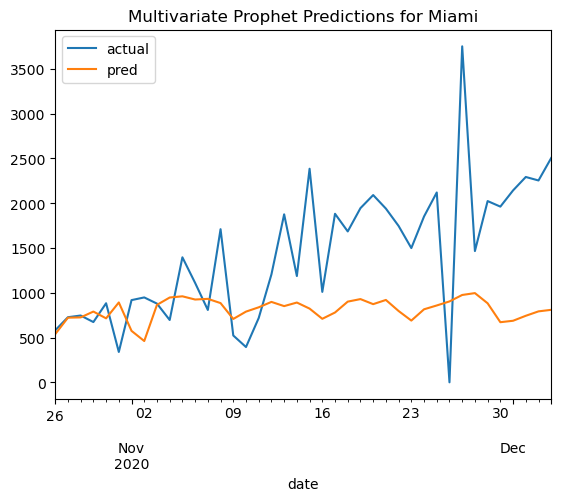

In [14]:


model=prophet.Prophet(holidays=events, holidays_prior_scale=0.01, changepoint_prior_scale=0.01, seasonality_prior_scale=0.1,
                                         seasonality_mode = 'additive',yearly_seasonality=True, weekly_seasonality=True)
model.add_country_holidays(country_name='US')
test.fillna(0, inplace=True)
train.fillna(0, inplace=True)
for ii in train.columns:
    if ii == 'index':
        continue
    if ii == 'ds':
        continue
    if ii == 'cases':
        continue
    if ii == 'y':
        continue
    model.add_regressor(ii)
model.fit(train)
pred = model.predict(test)


prediction = pd.DataFrame({'actual':test.y.reset_index(drop = True), 
              'pred':pred.yhat.reset_index(drop = True)})
prediction['date'] = pd.to_datetime(test['ds'].reset_index(drop = True))
prediction.plot(x = 'date', y = ['actual', 'pred'], title='Multivariate Prophet Predictions for Miami')

In [15]:
from sklearn.metrics import mean_absolute_percentage_error

mean_absolute_percentage_error(prediction[prediction['actual'] != 0].actual, prediction[prediction['actual'] != 0].pred)

0.45883676344203933

00:18:53 - cmdstanpy - INFO - Chain [1] start processing
00:18:53 - cmdstanpy - INFO - Chain [1] done processing


<Axes: title={'center': 'Multivariate Prophet Predictions for Chicago'}, xlabel='date'>

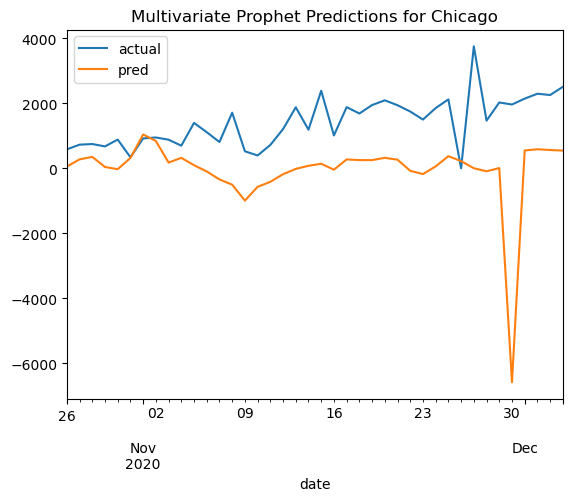

In [16]:


model=prophet.Prophet()
model.add_country_holidays(country_name='US')
test.fillna(0, inplace=True)
train.fillna(0, inplace=True)
for ii in train.columns:
    if ii == 'index':
        continue
    if ii == 'ds':
        continue
    if ii == 'cases':
        continue
    if ii == 'y':
        continue
    model.add_regressor(ii)
model.fit(train)
pred = model.predict(test)


prediction = pd.DataFrame({'actual':test.y.reset_index(drop = True), 
              'pred':pred.yhat.reset_index(drop = True)})
prediction['date'] = pd.to_datetime(test['ds'].reset_index(drop = True))
prediction.plot(x = 'date', y = ['actual', 'pred'], title='Multivariate Prophet Predictions for Chicago')

In [17]:
from sklearn.metrics import mean_absolute_percentage_error

mean_absolute_percentage_error(prediction[prediction['actual'] != 0].actual, prediction[prediction['actual'] != 0].pred)

1.0541218385190372

In [24]:
from sklearn.model_selection import TimeSeriesSplit
from sklearn.metrics import mean_squared_error
import numpy as np

train.reset_index(inplace=True)

n_splits = 3

tscv = TimeSeriesSplit(n_splits=n_splits)

changepoint_prior_scale = [0.001, 0.01, 0.1, 0.5]
seasonality_prior_scale =  [0.01, 0.1, 1.0, 10.0]
holidays_prior_scale = [0.01, 0.1, 1.0, 10.0]
seasonality_mode = ['additive', 'multiplicative']

best_score, best_cfg = float("inf"), None


    
for h in holidays_prior_scale:
    for c in changepoint_prior_scale:
        for s in seasonality_prior_scale:
            for m in seasonality_mode:
                avg = 0
                for train_index, val_index in tscv.split(train):
                    train_data, val_data = train.loc[train_index, :], train.loc[val_index, :]
                    model=prophet.Prophet(holidays=events, holidays_prior_scale=h, changepoint_prior_scale=c, seasonality_prior_scale=s,
                                         seasonality_mode = m)
                    model.add_country_holidays(country_name='US')
                    model.fit(train_data)
                    future = model.make_future_dataframe(periods=val_data.shape[0])
                    future = future[future['ds'] > train_data.ds.iloc[-1]]
                    forecast = model.predict(future)
                    mse = mean_squared_error(val_data.y, forecast.yhat)
                    avg += mse
                if avg < best_score:
                    best_score, best_cfg = avg, (h,c,s,m)

print(f'Best ARIMA parameters: {best_cfg} with MSE: {best_score}')

14:25:44 - cmdstanpy - INFO - Chain [1] start processing
14:25:49 - cmdstanpy - INFO - Chain [1] done processing
14:25:50 - cmdstanpy - INFO - Chain [1] start processing
14:25:50 - cmdstanpy - INFO - Chain [1] done processing
14:25:50 - cmdstanpy - ERROR - Chain [1] error: error during processing Operation not permitted
Optimization terminated abnormally. Falling back to Newton.
14:25:50 - cmdstanpy - INFO - Chain [1] start processing
14:25:50 - cmdstanpy - INFO - Chain [1] done processing
14:25:51 - cmdstanpy - INFO - Chain [1] start processing
14:25:51 - cmdstanpy - INFO - Chain [1] done processing
14:25:51 - cmdstanpy - ERROR - Chain [1] error: error during processing Operation not permitted
Optimization terminated abnormally. Falling back to Newton.
14:25:51 - cmdstanpy - INFO - Chain [1] start processing
14:25:55 - cmdstanpy - INFO - Chain [1] done processing
14:25:55 - cmdstanpy - INFO - Chain [1] start processing
14:26:01 - cmdstanpy - INFO - Chain [1] done processing
14:26:01 -

Best ARIMA parameters: (0.1, 0.5, 10.0, 'additive') with MSE: 3941213.8781684698


15:02:29 - cmdstanpy - INFO - Chain [1] start processing
15:02:29 - cmdstanpy - INFO - Chain [1] done processing


-1.7588584595700625


<Axes: xlabel='date'>

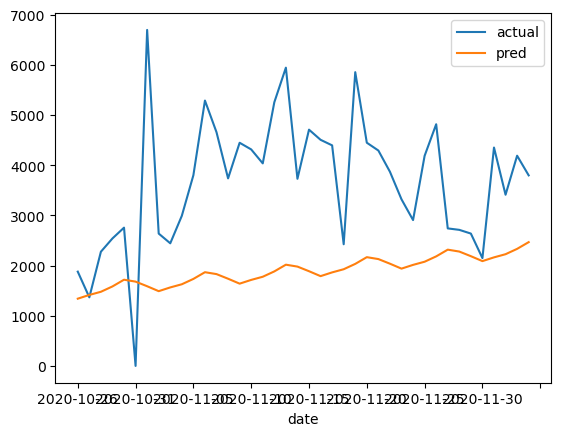

In [25]:


model=prophet.Prophet(holidays=events, holidays_prior_scale=0.1, changepoint_prior_scale=0.5, seasonality_prior_scale=10,
                                         seasonality_mode = 'additive')
model.add_country_holidays(country_name='US')
model.fit(train)
future = model.make_future_dataframe(periods=40)
future = future[future['ds'] > train.ds.iloc[-1]]
pred = model.predict(future)


r2 = r2_score(test.y, pred.yhat)
print(r2)

prediction = pd.DataFrame({'actual':test.y.reset_index(drop = True), 
              'pred':pred.yhat.reset_index(drop = True)})
prediction['date'] = test['ds'].reset_index(drop = True)
prediction.plot(x = 'date', y = ['actual', 'pred'])